# Scoping

Let's go shopping for the best Canola farmland, using public commodity pricing to calculate valuations.

In [272]:
import seaborn as sns
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
from shapely.geometry import Polygon

# visualizations
import folium
from folium import features
from folium import plugins
from folium.plugins import TimeSliderChoropleth
import pandas as pd
import json
from branca.colormap import linear

# models
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from scipy.stats import skew, kurtosis

## Define Defaults / Constants

In [2]:
# set default file path
file_path = '/Users/clintonboyda/Documents/GitHub/Palette_Cohort_4/'
# note most output will be saved in the Data folder of this path

In [3]:
crop_columns=['Canola', 'Barley', 'Canary Seed', 'Durum Wheat',
       'Lentils', 'Oats', 'Spring Wheat', 'Peas']

In [4]:
target_crop=['Canola']

In [5]:
show_maps=False

# Helper Functions

In [6]:
def cleanup(variables) -> None:
    """
    This function attempts to release the memory occupied by one or more variables by using the 'del' statement.
    
    Args:
        variables (str or list): The name(s) of the variable(s) to be deleted. It can be a single string or a list of strings.

    Returns:
        None

    Raises:
        KeyError: If a variable with a specified name does not exist in the global namespace.
        Exception: If any other exceptions occur during the deletion process.

    Example usage:
        # Single variable
        df_data_mb = "Some data"
        cleanup("df_data_mb")
        
        # List of variables
        variables_to_cleanup = ["var1", "var2", "var3"]
        cleanup(variables_to_cleanup)
    """
    if isinstance(variables, str):
        variables = [variables]

    for variable_name in variables:
        try:
            del globals()[variable_name]
        except KeyError:
            raise KeyError(f"Error: The variable '{variable_name}' does not exist.")
        except Exception as e:
            raise Exception(f"An error occurred: {str(e)}")


In [7]:
# Function to compute additional cluster statistics
def additional_cluster_statistics(clustered_dataframe, cluster_label_column, feature_column):

    """
    Computes additional statistics like count, min, max, skewness, and kurtosis for each cluster.
    
    Parameters:
        data (DataFrame): The clustered data.
        cluster_column (str): The column containing the cluster labels.
        feature (str): The feature for which to compute additional statistics.
        
    Returns:
        DataFrame: A DataFrame containing the additional statistics for each cluster.
    Example usage:
        df = pd.DataFrame({
            'Cluster': [0, 0, 1, 1, 2],
            'Value': [10, 20, 30, 40, 50]
        })
        additional_stats = additional_cluster_statistics(df, 'Cluster', 'Value')
    """
    stats = clustered_dataframe.groupby(cluster_label_column)[feature_column].agg(['count', 'min', 'max', 'mean', 'median', 'std', skew, kurtosis]).reset_index()
    return stats


# Examples
# #  Compute additional statistics for k=2 clusters
# # additional_stats_k2 = additional_cluster_statistics(df_yield_value_year.rename(columns={'Cluster_k2': 'Cluster'}), 'Cluster', 'Value')

# #  Compute additional statistics for k=4 clusters
# # additional_stats_k4 = additional_cluster_statistics(clustered_data_single, 'Cluster', 'Value')

# # additional_stats_k2, additional_stats_k4


In [8]:
def calculate_silhouette_scores(data, cluster_labels):
    """
    Calculate the average silhouette score for a given set of data points and their cluster assignments.
    
    Parameters:
        data (array-like, shape (n_samples, n_features)): The data points for which to calculate silhouette scores.
        cluster_labels (array-like, shape (n_samples,)): Cluster assignments for each data point.

    Returns:
        float: The average silhouette score.
    """
    silhouette_avg = np.mean(silhouette_samples(data, cluster_labels))
    return silhouette_avg

# Example usage:
# - data: Your data (e.g., df_yield_value_year_standardized_single[['Value']])
# - cluster_labels: Cluster assignments for a specific number of clusters (e.g., df_yield_value_year['Cluster_k2'])


In [9]:
def silhouette_analysis(data, max_clusters):
    """
    Perform silhouette analysis and plot the silhouette scores for different numbers of clusters.
    
    Parameters:
        data (DataFrame): The data to be clustered.
        max_clusters (int): The maximum number of clusters to consider.
        
    Returns:
        None: Plots the silhouette analysis.
    """
    silhouette_scores = []  # To store silhouette scores for each k

    for n_clusters in range(2, max_clusters + 1):
        # Initialize the clusterer with n_clusters value and a random generator seed for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = clusterer.fit_predict(data)

        # Compute the silhouette score
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, cluster_labels)

        # Plot the silhouette scores
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(10, 6)

        ax1.fill_betweenx(np.arange(len(sample_silhouette_values)), 0, sample_silhouette_values,
                          facecolor="turquoise", edgecolor="turquoise", alpha=0.7)

        ax1.set_title(f"Silhouette Plot for {n_clusters} Clusters")
        ax1.set_xlabel("silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        plt.show()

    # Plot silhouette scores against number of clusters
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', linestyle='-')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.grid(True)

    # Create a DataFrame for the silhouette scores
    silhouette_df = pd.DataFrame({'Number of Clusters': range(2, max_clusters + 1), 'Silhouette Score Percentage': silhouette_scores})

    # Print a nicely formatted table of silhouette scores
    print("\nSilhouette Scores for Different Numbers of Clusters:")
    print(silhouette_df)

    plt.show()

# Example usage:
# silhouette_analysis(your_data, max_clusters)


In [10]:
# Redefining the Elbow Method function
def elbow_method(data, max_clusters):
    """
    Plots the Within-Cluster-Sum-of-Squares (WCSS) for a range of cluster numbers to find the 'elbow'.
    
    Parameters:
        data (DataFrame): The data to be clustered.
        max_clusters (int): The maximum number of clusters to consider.
        
    Returns:
        None: A plot is generated.
    """
    wcss = []  # List to store the within-cluster sum of squares for each k

    # Perform k-means clustering for k=1 to k=max_clusters and record WCSS
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Plotting the WCSS values
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.grid(True)
    plt.show()

In [11]:
# Function to perform k-means clustering and add cluster labels to the original data
def perform_kmeans(data, n_clusters):
    """
    Performs k-means clustering and adds the cluster labels to the original data.
    
    Parameters:
        data (DataFrame): The data to be clustered.
        n_clusters (int): The number of clusters.
        
    Returns:
        DataFrame: A new DataFrame with an additional column containing the cluster labels.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(data)
    labels = kmeans.labels_
    
    # Adding the cluster labels to the original data
    clustered_data = data.copy()
    clustered_data['Cluster'] = labels
    
    return clustered_data

In [12]:
def format_summary_stats(summary_stats):
    """
    Formats summary statistics for clusters based on the Value feature.

    Args:
    summary_stats (DataFrame): A DataFrame containing summary statistics for clusters.

    Returns:
    str: A formatted string with summary statistics for each cluster.
    """
    formatted_output = "The summary statistics for each of the four clusters based on the Value feature are as follows:\n\n"

    for index, row in summary_stats.iterrows():
        formatted_output += f"Cluster {row['Cluster']}:\n"
        formatted_output += f"Value: Mean = {row['Value_mean']:.2f}, Median = {row['Value_median']:.2f}, Std = {row['Value_std']:.2f}\n"

    return formatted_output
# Assuming summary_stats_single_flat is the flattened DataFrame
#print("k-Means Results: " + format_summary_stats(summary_stats_single))
# ensure summary_stats_single in this example is flattened with columns

In [13]:
# Function to visualize the distribution of the 'Value' feature within each cluster using a histogram
def visualize_single_feature_clusters(data, feature, clust):
    """
    Creates a histogram to visualize the distribution of a single feature within each cluster.
    
    Parameters:
        data (DataFrame): The clustered data.
        feature (str): The feature to visualize.
        clust (str): Cluster column name
        
    Returns:
        None: A plot is generated.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(data, x=feature, hue=clust, element='step', stat='density', common_norm=False)
    plt.title(f'Distribution of {feature} Within Each Cluster')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend(title=clust)
    plt.grid(True)
    plt.show()

# Visualize the distribution of 'Value' within each cluster
# visualize_single_feature_clusters(clustered_data_single, 'Value')


In [14]:
# Function to create a violin plot for the clusters using original values
def visualize_clusters_violin(data, feature, clust):
    """
    Creates a violin plot to visualize the distribution of a single original feature within each cluster.
    
    Parameters:
        data (DataFrame): The clustered data with original values.
        feature (str): The feature to visualize.
        clust (str): The cluster labels column name in the DataFrame.
        
    Returns:
        None: A plot is generated.
    """
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=clust, y=feature, data=data, palette='viridis')
    plt.title(f'Distribution of Original {feature} Within Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.grid(True)
    # Add labels to the legend
    #plt.legend(title="Clusters", labels=["0", "1", "2", "3"])
    plt.show()

# Create a violin plot for the clusters using original 'Value'
# visualize_clusters_violin(df_yield_value_year_clean, 'Value', 'Cluster')


In [15]:
# Function to visualize the clusters in a scatter plot for a single feature using original values
def visualize_single_feature_scatter_original(data, feature):
    """
    Creates a scatter plot to visualize the clusters based on a single original feature.
    
    Parameters:
        data (DataFrame): The clustered data with original values.
        feature (str): The feature to visualize.
        
    Returns:
        None: A plot is generated.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x=feature, y=np.zeros(len(data)), hue='Cluster', palette='viridis', s=50, alpha=0.6)
    plt.title(f'Clusters based on Original {feature}')
    plt.xlabel(feature)
    plt.yticks([])  # Hide y-axis
    #plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

# Visualize the clusters based on original 'Value' using a scatter plot
# visualize_single_feature_scatter_original(df_yield_value_year_clean, 'Value')

In [16]:
# Function to visualize the clusters in a scatter plot for a single feature
def visualize_single_feature_scatter(data, feature):
    """
    Creates a scatter plot to visualize the clusters based on a single feature.
    
    Parameters:
        data (DataFrame): The clustered data.
        feature (str): The feature to visualize.
        
    Returns:
        None: A plot is generated.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x=feature, y=np.zeros(len(data)), hue='Cluster', palette='viridis', s=50, alpha=0.6)
    plt.title(f'Clusters based on {feature}')
    plt.xlabel(feature)
    plt.yticks([])  # Hide y-axis
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

# Visualize the clusters based on 'Value' using a scatter plot
# visualize_single_feature_scatter(clustered_data_single, 'Value')


In [17]:
def silhouette_results_interpretation(silhouette_avg):
    """
    Interpret the Silhouette Score and provide a meaningful description.

    Args:
        silhouette_avg (float): The Silhouette Score to be interpreted.

    Returns:
        str: A description of the Silhouette Score's meaning.
    """
    if silhouette_avg == 1:
        interpretation = "Silhouette Score: 1.0 (Perfectly Separated Clusters)"
        interpretation += "\nThis indicates that the clusters are perfectly separated."
    elif silhouette_avg > 0.5:
        interpretation = f"Silhouette Score: {silhouette_avg:.4f} (Strongly Separated Clusters)"
        interpretation += "\nThis indicates that the clusters are well-separated."
    elif silhouette_avg > 0:
        interpretation = f"Silhouette Score: {silhouette_avg:.4f} (Reasonably Separated Clusters)"
        interpretation += "\nThis indicates that the clusters are reasonably well-separated."
    elif silhouette_avg == 0:
        interpretation = "Silhouette Score: 0.0 (Overlapping Clusters)"
        interpretation += "\nThis indicates that the clusters are overlapping."
    else:
        interpretation = f"Silhouette Score: {silhouette_avg:.4f} (Poorly Separated Clusters)"
        interpretation += "\nThis indicates that the clusters are poorly separated."
    
    return interpretation

# Example usage:
# silhouette_avg = 0.6721  # Replace with your actual Silhouette Score
# interpretation = silhouette_results_interpretation(silhouette_avg)
# print(interpretation)


In [18]:
# Function to perform DBSCAN clustering
def perform_dbscan(data, eps, min_pts):
    dbscan = DBSCAN(eps=eps, min_samples=min_pts)
    cluster_labels = dbscan.fit_predict(data)
    clustered_data = data.copy()
    clustered_data['Cluster'] = cluster_labels
    return clustered_data

# Function to compute cluster summary statistics
def cluster_summary_statistics(data, cluster_column, features):
    return data.groupby(cluster_column)[features].agg(['mean', 'median', 'std'])


# ETL (Extract, Transform, Load)

In [19]:
# Set plot defaults
plt.rcParams['figure.figsize'] = [12, 8] # figure size
plt.rcParams['font.size'] = 12 # font size
plt.rcParams['font.family'] = 'Arial'
# lines and markers
plt.rcParams['lines.linestyle'] = '-'
plt.rcParams['lines.marker'] = 'o'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['savefig.format'] = 'pdf'

## Extracting

### Extract: Yield Data

In [20]:
df_data_sk = pd.read_csv(file_path + 'Data/rm-yields-data.csv')

In [21]:
df_data_mb = pd.read_excel(file_path + 'Data/MMPP - Yield by Soil Type Browser.xlsx')

### Extract: Mapping Geospatial Shapefiles

Grab GeoDataFrames for geospatial data presentations.

In [22]:
gdf_sk=gpd.read_file(file_path + 'Data/RuralMunicipality.shp')

In [23]:
gdf_sk.columns

Index(['PPID', 'EFFDT', 'EXPDT', 'FEATURECD', 'RMNO', 'RMNM', 'SHAPE_AREA',
       'SHAPE_LEN', 'geometry'],
      dtype='object')

In [24]:
gdf_sk['RMNM'].nunique()

297

In [25]:
gdf_mb=gpd.read_file(file_path + 'Data/MB_Municipal_Boundaries.shp')

In [26]:
gdf_mb.columns

Index(['MUNI_NO', 'MUNI_NAME', 'MUNI_TYPE', 'Shape_Leng', 'Shape_Area', 'NAME',
       'NAME_TYPE', 'geometry'],
      dtype='object')

In [27]:
gdf_mb['MUNI_NAME'].nunique()

183

## Transforming

### Transform Yield Data

#### Transform: Yield Data for Manitoba

In [28]:
df_data_mb.columns

Index(['Year', 'Risk Area / R.M.', 'Crop', 'Soil', 'Farms', 'Acres',
       'Yield/acre(Metric)', 'Yield/acre(Metric).1', 'Yield/acre(Imperial)'],
      dtype='object')

In [29]:
df_data_mb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79256 entries, 0 to 79255
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Year                  79256 non-null  int64 
 1   Risk Area / R.M.      79256 non-null  object
 2   Crop                  79256 non-null  object
 3   Soil                  79256 non-null  object
 4   Farms                 79256 non-null  object
 5   Acres                 79256 non-null  object
 6   Yield/acre(Metric)    79256 non-null  object
 7   Yield/acre(Metric).1  38637 non-null  object
 8   Yield/acre(Imperial)  38637 non-null  object
dtypes: int64(1), object(8)
memory usage: 5.4+ MB


In [30]:
# Table heads
df_data_mb.head()

,Year,Risk Area / R.M.,Crop,Soil,Farms,Acres,Yield/acre(Metric),Yield/acre(Metric).1,Yield/acre(Imperial)
0,2003,MONTCALM,CANARYSEED,D,7,764,0.452 Tonnes,Tonnes,997 Pounds
1,1998,HAMIOTA,LENTILS,B,8,"1,835.0",0.451 Tonnes,Tonnes,994 Pounds
2,2005,THOMPSON,WHITE PEA BEANS,E,11,"1,253.0",0.451 Tonnes,Tonnes,994 Pounds
3,1997,RHINELAND,WHITE PEA BEANS,C,29,"3,399.0",0.450 Tonnes,Tonnes,992 Pounds
4,2004,PIPESTONE,CANARYSEED,F,8,"1,180.0",0.449 Tonnes,Tonnes,991 Pounds


In [31]:
df_data_mb['Yield/acre(Metric)']=df_data_mb['Yield/acre(Metric)'].str.replace(' Tonnes', '') # Replacing Tonnes
df_data_mb['Yield/acre(Metric)']=df_data_mb['Yield/acre(Metric)'].replace('Tolerance', np.NaN) # Replacing Tolerance
df_data_mb['Yield/acre(Metric)']=df_data_mb['Yield/acre(Metric)'].astype(float) # changing object to float data type

In [32]:
df_data_mb_pivot=pd.pivot_table(df_data_mb.drop(columns=['Yield/acre(Metric).1', 'Yield/acre(Imperial)', 'Soil', 'Farms' ]),
               index=['Risk Area / R.M.', 'Year'], columns='Crop', values='Yield/acre(Metric)')\
               .reset_index()

In [33]:
df_data_mb_pivot.columns

Index(['Risk Area / R.M.', 'Year', 'ALFALFA', 'ARGENTINE CANOLA', 'BARLEY',
       'CANARYSEED', 'DURUM WHEAT', 'FABABEANS', 'LENTILS', 'OATS',
       'POLISH CANOLA', 'RED SPRING WHEAT', 'WHITE PEA BEANS'],
      dtype='object', name='Crop')

In [34]:
df_data_mb_clean=df_data_mb_pivot.rename(columns={
    'Risk Area / R.M.': 'RM',
    'ARGENTINE CANOLA': 'Canola',
    'BARLEY':'Barley',
    'CANARYSEED': 'Canary Seed',
    'DURUM WHEAT': 'Durum Wheat',
     'LENTILS': 'Lentils',
     'OATS': 'Oats',
    'RED SPRING WHEAT': 'Spring Wheat',
    'WHITE PEA BEANS': 'Peas'}) \
        .drop(columns=['ALFALFA', 'FABABEANS', 'FABABEANS', 'POLISH CANOLA'] )

In [35]:
df_data_mb_clean

Crop,RM,Year,Canola,Barley,Canary Seed,Durum Wheat,Lentils,Oats,Spring Wheat,Peas
0,ALEXANDER,1993,0.251000,NaN,NaN,NaN,NaN,NaN,0.338000,NaN
1,ALEXANDER,1994,0.289000,NaN,NaN,NaN,NaN,NaN,0.587333,NaN
2,ALEXANDER,1995,0.620000,NaN,NaN,NaN,NaN,NaN,0.669500,NaN
3,ALEXANDER,1996,0.755333,1.6955,0.212,NaN,NaN,0.956000,0.976500,NaN
4,ALEXANDER,1997,0.651333,NaN,NaN,NaN,NaN,1.184000,0.971750,NaN
...,...,...,...,...,...,...,...,...,...,...
2800,YELLOWHEAD,2018,1.122333,1.9260,NaN,NaN,NaN,2.094000,1.857333,NaN
2801,YELLOWHEAD,2019,0.963500,1.8620,NaN,NaN,NaN,1.740500,1.660000,NaN
2802,YELLOWHEAD,2020,0.968000,1.9245,NaN,NaN,NaN,1.725667,1.631667,NaN
2803,YELLOWHEAD,2021,0.888000,1.7200,NaN,NaN,NaN,1.651500,1.582000,NaN


In [36]:
# Crop conversion in MB tonnes to bushel
df_data_mb_clean['Canola']=df_data_mb_clean['Canola'] * 44.092
df_data_mb_clean['Barley']=df_data_mb_clean['Barley'] * 45.93
df_data_mb_clean['Canary Seed']=df_data_mb_clean['Canary Seed'] * 44.092
df_data_mb_clean['Durum Wheat']=df_data_mb_clean['Durum Wheat'] * 36.74
df_data_mb_clean['Lentils']=df_data_mb_clean['Lentils'] * 36.74
df_data_mb_clean['Oats']=df_data_mb_clean['Oats'] * 64.842
df_data_mb_clean['Spring Wheat']=df_data_mb_clean['Spring Wheat'] * 36.74
df_data_mb_clean['Peas']=df_data_mb_clean['Peas'] *  36.74


In [37]:
# Creating province column
df_data_mb_clean['Province'] = 'MB'


#### Transform: Yield Data for Saskatchewan

In [38]:
# List of columns
df_data_sk.columns

Index(['Year', 'RM', 'Winter Wheat', 'Canola', 'Spring Wheat', 'Mustard',
       'Durum', 'Sunflowers', 'Oats', 'Lentils', 'Peas', 'Barley', 'Fall Rye',
       'Canary Seed', 'Spring Rye', 'Tame Hay', 'Flax', 'Chickpeas'],
      dtype='object')

In [39]:
# Info about columns
df_data_sk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25312 entries, 0 to 25311
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          25312 non-null  int64  
 1   RM            25312 non-null  int64  
 2   Winter Wheat  3073 non-null   float64
 3   Canola        14299 non-null  float64
 4   Spring Wheat  25213 non-null  float64
 5   Mustard       4584 non-null   float64
 6   Durum         11753 non-null  float64
 7   Sunflowers    946 non-null    float64
 8   Oats          24148 non-null  float64
 9   Lentils       5711 non-null   float64
 10  Peas          8421 non-null   float64
 11  Barley        24987 non-null  float64
 12  Fall Rye      15887 non-null  float64
 13  Canary Seed   3880 non-null   float64
 14  Spring Rye    805 non-null    float64
 15  Tame Hay      4205 non-null   float64
 16  Flax          21146 non-null  float64
 17  Chickpeas     1014 non-null   float64
dtypes: float64(16), int64(2)
m

In [40]:
# Table heads
df_data_sk.head()

,Year,RM,Winter Wheat,Canola,Spring Wheat,Mustard,Durum,Sunflowers,Oats,Lentils,Peas,Barley,Fall Rye,Canary Seed,Spring Rye,Tame Hay,Flax,Chickpeas
0,1938,1,NaN,NaN,4.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN
1,1939,1,NaN,NaN,9.0,NaN,NaN,NaN,16.0,NaN,NaN,16.0,NaN,NaN,NaN,NaN,0.0,NaN
2,1940,1,NaN,NaN,12.0,NaN,NaN,NaN,23.0,NaN,NaN,19.0,NaN,NaN,NaN,NaN,8.0,NaN
3,1941,1,NaN,NaN,18.0,NaN,NaN,NaN,32.0,NaN,NaN,28.0,NaN,NaN,NaN,NaN,5.0,NaN
4,1942,1,NaN,NaN,20.0,NaN,NaN,NaN,35.0,NaN,NaN,28.0,14.0,NaN,NaN,NaN,5.0,NaN


In [41]:
df_data_sk.columns

Index(['Year', 'RM', 'Winter Wheat', 'Canola', 'Spring Wheat', 'Mustard',
       'Durum', 'Sunflowers', 'Oats', 'Lentils', 'Peas', 'Barley', 'Fall Rye',
       'Canary Seed', 'Spring Rye', 'Tame Hay', 'Flax', 'Chickpeas'],
      dtype='object')

In [42]:
df_data_sk_clean=df_data_sk.rename(columns={'Durum': 'Durum Wheat'}).drop(columns=['Winter Wheat', 'Mustard', 'Sunflowers', 'Fall Rye', 'Spring Rye', 'Tame Hay','Flax', 'Chickpeas' ] )

In [43]:
df_data_sk_clean

,Year,RM,Canola,Spring Wheat,Durum Wheat,Oats,Lentils,Peas,Barley,Canary Seed
0,1938,1,NaN,4.0,NaN,1.0,NaN,NaN,1.0,NaN
1,1939,1,NaN,9.0,NaN,16.0,NaN,NaN,16.0,NaN
2,1940,1,NaN,12.0,NaN,23.0,NaN,NaN,19.0,NaN
3,1941,1,NaN,18.0,NaN,32.0,NaN,NaN,28.0,NaN
4,1942,1,NaN,20.0,NaN,35.0,NaN,NaN,28.0,NaN
...,...,...,...,...,...,...,...,...,...,...
25307,2018,622,39.3,59.5,NaN,96.4,NaN,43.0,54.0,NaN
25308,2019,622,46.1,63.9,NaN,106.0,NaN,33.7,73.9,NaN
25309,2020,622,40.9,55.1,NaN,94.5,NaN,49.2,74.3,NaN
25310,2021,622,23.9,17.0,NaN,25.8,NaN,NaN,23.3,NaN


In [44]:
# Crop Conversion in SK - pounds to bushels
df_data_sk_clean['Lentils']=df_data_sk_clean['Lentils'] / 60
df_data_sk_clean['Canary Seed']=df_data_sk_clean['Canary Seed'] / 50

In [45]:
# Creating province column
df_data_sk_clean['Province'] = 'SK'

### Merge Transformed Data

In [46]:
df_data_merged = pd.concat([df_data_mb_clean, df_data_sk_clean])

In [47]:
if show_maps:
    # Pearson Corr (-1 to 1), -1 negative corr, o no corr, 1 positive corr
    # Using Seaborn, inserted here before we nuke the irrelevant crop columns
    sns.heatmap(df_data_merged[crop_columns].corr(),annot=True, cmap='Greens')


In [48]:
df_data_merged['RM']=df_data_merged['RM'].astype('string')

In [49]:
# remove other crop data, since we are focusing on Canola

# Remove 'Canola' from crop_columns if it exists
if 'Canola' in crop_columns:
    crop_columns.remove('Canola')

# Drop the columns in crop_columns from the DataFrame
df_data_merged = df_data_merged.drop(columns=crop_columns)
df_data_merged = df_data_merged.drop(columns="Province")

# Add 'Canola' back to crop_columns
crop_columns.append('Canola')


In [50]:
df_data_merged

,RM,Year,Canola
0,ALEXANDER,1993,11.067092
1,ALEXANDER,1994,12.742588
2,ALEXANDER,1995,27.337040
3,ALEXANDER,1996,33.304157
4,ALEXANDER,1997,28.718589
...,...,...,...
25307,622,2018,39.300000
25308,622,2019,46.100000
25309,622,2020,40.900000
25310,622,2021,23.900000


#### Cleanup Crop Variables

In [51]:
# remove unneeded variables
cleanup(["df_data_mb_pivot","df_data_sk","df_data_mb","df_data_sk_clean","df_data_mb_clean"])

# GIS Analysis

In [52]:
# CRS --> Cordinate Reference Systems
gdf_mb['geometry'].crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [53]:
# Standardazing CRS formats
gdf_sk['geometry']=gdf_sk['geometry'].to_crs('epsg:4326')
gdf_mb['geometry']=gdf_mb['geometry'].to_crs('epsg:4326')

In [54]:
gdf_sk.count()

PPID          298
EFFDT         298
EXPDT           0
FEATURECD     298
RMNO          298
RMNM          298
SHAPE_AREA    298
SHAPE_LEN     298
geometry      298
dtype: int64

In [55]:
gdf_mb.count()

MUNI_NO       183
MUNI_NAME     183
MUNI_TYPE     183
Shape_Leng    183
Shape_Area    183
NAME          183
NAME_TYPE     183
geometry      183
dtype: int64

In [56]:
gdf_sk['RMNO']=gdf_sk['RMNO'].astype(int)

In [57]:
# clean up Municipal Naming Conventions
gdf_mb['MUNI_NAME']=gdf_mb['MUNI_NAME'].str.replace('RM OF ','', regex=False) # not caps sensitive
gdf_mb['MUNI_NAME']=gdf_mb['MUNI_NAME'].str.replace('MUNICIPALITY OF ','', regex=False) # not caps sensitive
gdf_mb['MUNI_NAME']=gdf_mb['MUNI_NAME'].str.replace(' MUNICIPALITY','', regex=False) # not caps sensitive
gdf_mb['MUNI_NAME']=gdf_mb['MUNI_NAME'].str.replace('CITY OF ','', regex=False) # not caps sensitive

In [58]:
gdf=pd.concat([gdf_sk[['RMNO','geometry']].rename(columns={'RMNO':'RM'}),gdf_mb[['MUNI_NAME', 'geometry']].rename(columns={'MUNI_NAME':'RM'})])

In [59]:
gdf.count()

RM          481
geometry    481
dtype: int64

In [60]:
gdf['RM'].nunique()

478

In [61]:
gdf[gdf['RM'].duplicated(keep=False)]

,RM,geometry
20,PORTAGE LA PRAIRIE,"POLYGON ((-98.01460 50.30708, -98.01468 50.300..."
47,DAUPHIN,"POLYGON ((-100.05302 51.16755, -100.05311 51.1..."
62,THOMPSON,"POLYGON ((-97.82322 55.75650, -97.82778 55.753..."
64,PORTAGE LA PRAIRIE,"POLYGON ((-98.31913 49.97819, -98.31913 49.978..."
87,DAUPHIN,"POLYGON ((-100.27589 51.44871, -100.27560 51.4..."
90,THOMPSON,"POLYGON ((-98.06986 49.44333, -98.06985 49.436..."


In [62]:
# let's drop those duplicate RM in gdf
gdf = gdf.drop_duplicates(subset=['RM'], keep='first')

In [63]:
gdf.count()

RM          478
geometry    478
dtype: int64

In [64]:
gdf['RM']=gdf['RM'].astype('string')

In [65]:
# Any RM's in gdf missing the geometry values? We want this to be False
gdf['geometry'].isnull().any()

False

In [66]:
df_data_merged.count()

RM        28117
Year      28117
Canola    17001
dtype: int64

#### Cleanup GIS Variables

In [67]:
cleanup(["gdf_sk","gdf_mb"])

#### Missing Shapefiles for RM's with Crop Information

In [68]:
# List of 'RM' values missing from df_data_merged in gdf
missing_rm_in_df_data_merged = df_data_merged[~df_data_merged['RM'].isin(gdf['RM'])]['RM'].unique().tolist()
missing_rm_in_df_data_merged

['DESALABERRY',
 'EAST ST PAUL',
 'HILLSBURG-ROBLIN-SHELL RIVER',
 'KILLARNEY-TURTLE MTN',
 'NORFOLK-TREHERNE',
 'ST. FRANCIS XAVIER',
 'UNORG TERRITORY',
 '278',
 '408',
 '529']

In [69]:
# # Search in df_data_merged
# contains_xavier = df_data_merged[df_data_merged['RM'].str.contains('ROBLIN')]
# unique_rms = contains_xavier['RM'].unique()
# unique_rms

In [70]:
# # Search in GDF
# contains_xavier = gdf[gdf['RM'].str.contains('ROBLIN')]
# print(contains_xavier)


In [71]:
# Manual GIS Fixes
gdf.loc[gdf['RM'] == 'ST. FRANCOIS XAVIER', 'RM'] = 'ST. FRANCIS XAVIER'
gdf.loc[gdf['RM'] == 'DE SALABERRY', 'RM'] = 'DESALABERRY'
df_data_merged.loc[df_data_merged['RM'] == 'EAST ST PAUL', 'RM'] = 'EAST ST. PAUL'
df_data_merged.loc[df_data_merged['RM'] == 'KILLARNEY-TURTLE MTN', 'RM'] = 'KILLARNEY-TURTLE MOUNTAIN'
gdf.loc[gdf['RM'] == 'NORFOLK TREHERNE', 'RM'] = 'NORFOLK-TREHERNE'
gdf.loc[gdf['RM'] == 'ROBLIN', 'RM'] = 'HILLSBURG-ROBLIN-SHELL RIVER'

# The following RM's still are missing shape files: [278,529,408 from SK and UNORG TERRITORY from MB]


In [72]:
# List of 'RM' values missing from df_data_merged in gdf
missing_rm_in_df_data_merged = df_data_merged[~df_data_merged['RM'].isin(gdf['RM'])]['RM'].unique().tolist()
missing_rm_in_df_data_merged

['UNORG TERRITORY', '278', '408', '529']

In [73]:
print(f"Quality check, any missing RM values of gdf? {gdf['RM'].isna().sum()}")

Quality check, any missing RM values of gdf? 0


In [74]:
print(f"Quality check, any missing geometry values of gdf? {gdf[gdf['geometry'].isna()].sum(numeric_only=True)}")

Quality check, any missing geometry values of gdf? Series([], dtype: float64)


In [75]:
gdf.shape # only RM and geometery

# looks like
# RM	geometry
#0	95	POLYGON ((-102.84786 50.04713, -102.83663 50.0...
#1	378	POLYGON ((-108.45006 52.39118, -108.43824 52.3...


(478, 2)

In [76]:
df_data_merged.shape

(28117, 3)

In [77]:
# set method to check for missing values between RM's that exist in crop data but not in shapefiles
missing_rm_values = set(df_data_merged['RM']) - set(gdf['RM'])
sorted_missing_rm = sorted(list(missing_rm_values))
sorted_missing_rm

['278', '408', '529', 'UNORG TERRITORY']

### Merge Geometery and Crop Dataframes df_gdf

Now that all the RM names have been fixed and we are maximizing our RM shape geodataframe we can merge our crops with our shapefiles.

In [78]:
df_gdf=pd.merge(gdf, df_data_merged, on='RM') # inner join

In [79]:
df_gdf.shape

(27909, 4)

In [80]:
print('crop df_data_merged unique RMs:', df_data_merged['RM'].nunique())
print('GIS gdf unique RMs', gdf['RM'].nunique())
print('df_gdf unique RMs',df_gdf['RM'].nunique())

crop df_data_merged unique RMs: 397
GIS gdf unique RMs 478
df_gdf unique RMs 393


In [81]:
# Get the set of unique 'RM' values in df_data_merged
rm_set_df_data = set(df_data_merged['RM'])

# Get the set of unique 'RM' values in gdf
rm_set_gdf = set(gdf['RM'])

# Find the 'RM' values in df_data_merged that are missing in gdf
missing_rm_values = rm_set_df_data - rm_set_gdf

# Convert the result to a list
missing_rm_values_list = list(missing_rm_values)

# Print the missing 'RM' values
print("RM values in df_data_merged but missing in gdf:")
print(missing_rm_values_list)


RM values in df_data_merged but missing in gdf:
['408', 'UNORG TERRITORY', '278', '529']


In [82]:
df_data_merged.shape

(28117, 3)

In [83]:
df_gdf.count()

RM          27909
geometry    27909
Year        27909
Canola      16888
dtype: int64

So this shows us that we are losing data by trying to view with geo spatial information...

## Load: Export GIS Options

In [84]:
# attempt to reduce size of df_gdf/csv export
#df_gdf['geometry'] = df_gdf['geometry'].simplify(tolerance=0.01, preserve_topology=True)

In [85]:
# %pip install fastparquet
# %pip install pyarrow

In [86]:
# export as parquet, hopefully for smaller file size
#df_gdf.to_parquet(file_path + 'Data/merged2_MB_SK.parquet') # still 643MB

In [87]:
# export for archiving
# df_gdf.to_csv(file_path + 'Data/merged2_MB_SK.csv', index=False) # creates 2.14GB CSV file normally or 84MB when simplified

In [88]:
# to minimize missing Canola values

# Export the filtered DataFrame to "Crops_Yield_2002_2022.csv"
#df_data_merged[df_data_merged['Year'] > 2001].to_csv(file_path + 'Data/Crops_Yield_2002_2022.csv', index=False)

In [89]:
# try:
#     df_gdf.drop(columns='geometry').to_csv(file_path + 'Data/Crops_Yield_1938_2022.csv', index=False)
# except Exception as e:
#     print("An error occurred:", str(e))

In [90]:
# try:
#     df_gdf.loc[df_gdf['Year']==2020][['RM', 'geometry']] # 2020 since this is highest # of RMs
#     # Save as GIS
#     df_gdf.loc[df_gdf['Year']==2020][['RM', 'geometry']].to_file(file_path + 'Data/SK_MB_GIS_geodata.shp')
# except Exception as e:
#     print("An error occurred:", str(e))

# Grab Canola Stock Market Pricing

In [91]:
# Grab Canola Stock Price
# Stock historical values from https://www.investing.com/commodities/canola-futures-historical-data since 2002

# Read the CSV file
stock_file_upload = file_path + 'Data/Canola Futures Historical Data.csv'
df_price = pd.read_csv(stock_file_upload)
print(df_price.shape)
df_price.head() # Canola stock prices

(3285, 7)


,Date,Price,Open,High,Low,Vol.,Change %
0,10/11/2023,702.70,704.60,707.60,700.80,18.93K,-0.27%
1,10/10/2023,704.60,706.30,706.90,700.50,32.63K,-0.84%
2,10/06/2023,710.60,710.90,715.90,707.00,14.97K,-0.08%
3,10/05/2023,711.20,710.60,714.00,704.30,25.32K,0.06%
4,10/04/2023,710.80,718.90,719.40,710.50,15.87K,-0.92%


In [92]:
# Convert the 'Date' column to datetime type
df_price['Date'] = pd.to_datetime(df_price['Date'])

# Rename Price to reflect unit
df_price.rename(columns={'Price': 'Price_per_Tonne'}, inplace=True)

# To average the annual price, we first need to extract the year from the 'Date' column and create a new column for it
df_price['Year'] = df_price['Date'].dt.year

# Convert the 'Price' column to a numeric type, removing any non-numeric characters if necessary
df_price['Price_per_Tonne'] = pd.to_numeric(df_price['Price_per_Tonne'], errors='coerce')

# Drop any rows where 'Price' is NaN, if any
df_price.dropna(subset=['Price_per_Tonne'], inplace=True)

# Group by 'Year' and calculate the mean price for each year
#`df_price_by_year` is a DataFrame that contains the average annual price of canola futures. It is created by grouping the original DataFrame `df_price` by the 'Year' column and calculating the mean price for each year. The resulting DataFrame has columns 'Year', 'Price_per_Tonne', and 'Price_per_bushel'. The 'Price_per_Tonne' column represents the average annual price per tonne, while the 'Price_per_bushel' column represents the average annual price converted to bushels using a specific conversion factor.
df_price_by_year = df_price.groupby('Year')['Price_per_Tonne'].mean().reset_index()

# Convert stock price from tonnes to bushels to match our GIS data
specific_conversion_factor = 1 / 44.092  # 1 tonne = 44.092 bushels

# Apply the specific conversion factor to the 'Price' column
df_price_by_year['Price'] = df_price_by_year['Price_per_Tonne'] * specific_conversion_factor

# Rename the 'Price' column to 'Price_per_Tonne'
#df_price_by_year.rename(columns={'Price': 'Price_per_Tonne'}, inplace=True)
df_price_by_year = df_price_by_year.drop(columns=["Price_per_Tonne"])

df_price_by_year


,Year,Price
0,2010,11.584916
1,2011,12.697583
2,2012,13.619305
3,2013,12.712374
4,2014,10.011530
5,2015,10.752499
6,2016,10.991028
7,2017,11.557160
8,2018,11.419069
9,2019,10.354831


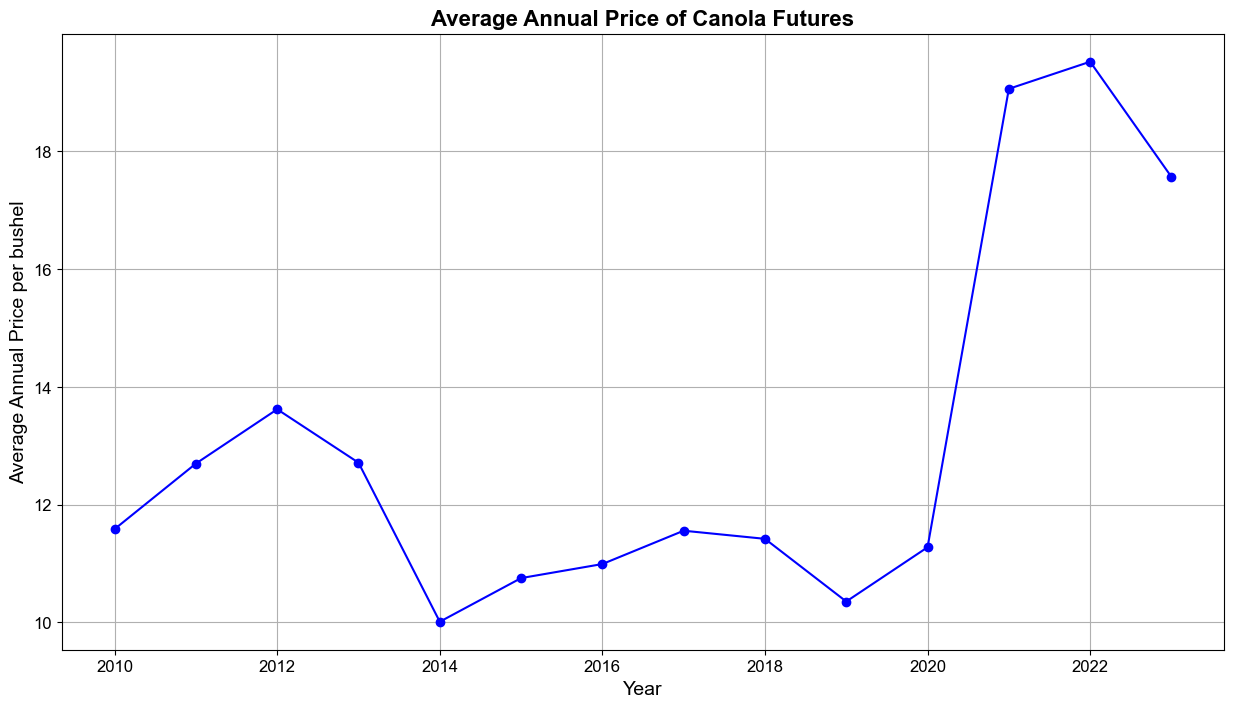

In [93]:
# Display the first few rows of the DataFrame to check the conversion
df_price_by_year.head()
# Plotting the averaged annual price data
plt.figure(figsize=(15, 8))
plt.plot(df_price_by_year['Year'], df_price_by_year['Price'], marker='o', linestyle='-', color='b')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Annual Price per bushel', fontsize=14)
plt.title('Average Annual Price of Canola Futures', fontsize=16)
plt.grid(True)
plt.show()

# Merge Yield and Stock Price of Canola

In [94]:
# Merge df_data_merged our crop data and df_price_by_year based on the 'Year' column
df_price_merged = df_data_merged.merge(df_price_by_year, on='Year', how='inner')
df_price_merged

,RM,Year,Canola,Price
0,ALEXANDER,2010,14.440130,11.584916
1,ALONSA,2010,17.989536,11.584916
2,ARGYLE,2010,42.970803,11.584916
3,ARMSTRONG,2010,11.419828,11.584916
4,BIFROST-RIVERTON,2010,9.523872,11.584916
...,...,...,...,...
5055,520,2022,47.900000,19.521513
5056,555,2022,39.900000,19.521513
5057,561,2022,28.200000,19.521513
5058,588,2022,35.900000,19.521513


#### Let's add a column 'Value' which is basically the yield x stock price for that year to show valuation for each RM.

In [95]:
# Calculate the 'Value' column by multiplying 'Price' with 'Canola' yield for each RM and year
df_price_merged['Value'] = df_price_merged['Price'] * df_price_merged['Canola']
df_price_merged

,RM,Year,Canola,Price,Value
0,ALEXANDER,2010,14.440130,11.584916,167.287689
1,ALONSA,2010,17.989536,11.584916,208.407259
2,ARGYLE,2010,42.970803,11.584916,497.813137
3,ARMSTRONG,2010,11.419828,11.584916,132.297745
4,BIFROST-RIVERTON,2010,9.523872,11.584916,110.333255
...,...,...,...,...,...
5055,520,2022,47.900000,19.521513,935.080458
5056,555,2022,39.900000,19.521513,778.908356
5057,561,2022,28.200000,19.521513,550.506658
5058,588,2022,35.900000,19.521513,700.822305


In [96]:
df_price_merged[df_price_merged.isnull().any(axis=1)]


,RM,Year,Canola,Price,Value
80,STUARTBURN,2010,NaN,11.584916,NaN
88,WEST INTERLAKE,2010,NaN,11.584916,NaN
89,WEST ST. PAUL,2010,NaN,11.584916,NaN
125,46,2010,NaN,11.584916,NaN
142,76,2010,NaN,11.584916,NaN
...,...,...,...,...,...
4757,WEST INTERLAKE,2022,NaN,19.521513,NaN
4796,51,2022,NaN,19.521513,NaN
4834,110,2022,NaN,19.521513,NaN
4932,279,2022,NaN,19.521513,NaN


In [97]:
# doesn't affect mean, but does affect std and median, need to remove
df_price_merged.dropna()

,RM,Year,Canola,Price,Value
0,ALEXANDER,2010,14.440130,11.584916,167.287689
1,ALONSA,2010,17.989536,11.584916,208.407259
2,ARGYLE,2010,42.970803,11.584916,497.813137
3,ARMSTRONG,2010,11.419828,11.584916,132.297745
4,BIFROST-RIVERTON,2010,9.523872,11.584916,110.333255
...,...,...,...,...,...
5055,520,2022,47.900000,19.521513,935.080458
5056,555,2022,39.900000,19.521513,778.908356
5057,561,2022,28.200000,19.521513,550.506658
5058,588,2022,35.900000,19.521513,700.822305


In [98]:
# slightly out of order, but now that we have a new value column, let's add that to df_gdf so we can visualize it

# Calculate the mean of 'Value' based on groupby 'Year' and 'RM' in df_price_merged
mean_value_by_year_rm = df_price_merged.groupby(['Year', 'RM'])['Value'].mean().reset_index()

# Round the 'Value' column to 2 decimal places
mean_value_by_year_rm['Value'] = mean_value_by_year_rm['Value'].round(2)

# Merge df_gdf with df_price_merged on the 'RM' and 'Year' columns
df_gdf = df_gdf.merge(mean_value_by_year_rm, on=['RM', 'Year'], how='left')

# Round the 'Canola' column in df_gdf to 2 decimal place accuracy
df_gdf['Canola'] = df_gdf['Canola'].round(3)

# Merge df_data_merged with df_price_merged on the 'RM' and 'Year' columns
df_data_merged = df_data_merged.merge(mean_value_by_year_rm, on=['RM', 'Year'], how='left')

# Round the 'Canola' column in df_data_merged to 2 decimal places accuracy
df_data_merged['Canola'] = df_data_merged['Canola'].round(3)

In [99]:
df_data_merged

,RM,Year,Canola,Value
0,ALEXANDER,1993,11.067,NaN
1,ALEXANDER,1994,12.743,NaN
2,ALEXANDER,1995,27.337,NaN
3,ALEXANDER,1996,33.304,NaN
4,ALEXANDER,1997,28.719,NaN
...,...,...,...,...
28112,622,2018,39.300,448.77
28113,622,2019,46.100,477.36
28114,622,2020,40.900,461.19
28115,622,2021,23.900,455.56


In [100]:
# Assuming df_price_merged contains your data
# Group by 'Year' and calculate the desired statistics for each column
grouped = df_price_merged.groupby('Year').agg({
    'Canola': ['mean', 'std', 'median'],
    'Price': ['mean', 'std', 'median'],
    'Value': ['mean', 'std', 'median']
})

# Flatten the multi-level column index
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]

# Reset the index to make 'Year' a regular column
df_value_agg_by_year = grouped.reset_index()

# Display the resulting DataFrame
df_value_agg_by_year

,Year,Canola_mean,Canola_std,Canola_median,Price_mean,Price_std,Price_median,Value_mean,Value_std,Value_median
0,2010,29.442351,7.642709,29.700000,11.584916,0.0,11.584916,341.087150,88.540138,344.071998
1,2011,29.105822,7.178546,30.300000,12.697583,0.0,12.697583,369.573598,91.150185,384.736777
2,2012,25.137916,4.460788,25.215823,13.619305,0.0,13.619305,342.360942,60.752838,343.421993
3,2013,39.099908,5.771026,39.268184,12.712374,0.0,12.712374,497.052653,73.363438,499.191849
4,2014,32.935778,6.667671,32.520000,10.011530,0.0,10.011530,329.737542,66.753591,325.574970
5,2015,37.157303,6.333025,37.745000,10.752499,0.0,10.752499,399.533874,68.095842,405.853087
6,2016,41.255478,5.544293,41.200000,10.991028,0.0,10.991028,453.440110,60.937476,452.830347
7,2017,36.723974,10.350115,37.590000,11.557160,0.0,11.557160,424.424853,119.617939,434.433657
8,2018,38.347932,8.206828,39.100000,11.419069,0.0,11.419069,437.897685,93.714342,446.485606
9,2019,40.914674,7.980801,42.100000,10.354831,0.0,10.354831,423.664531,82.639841,435.938377


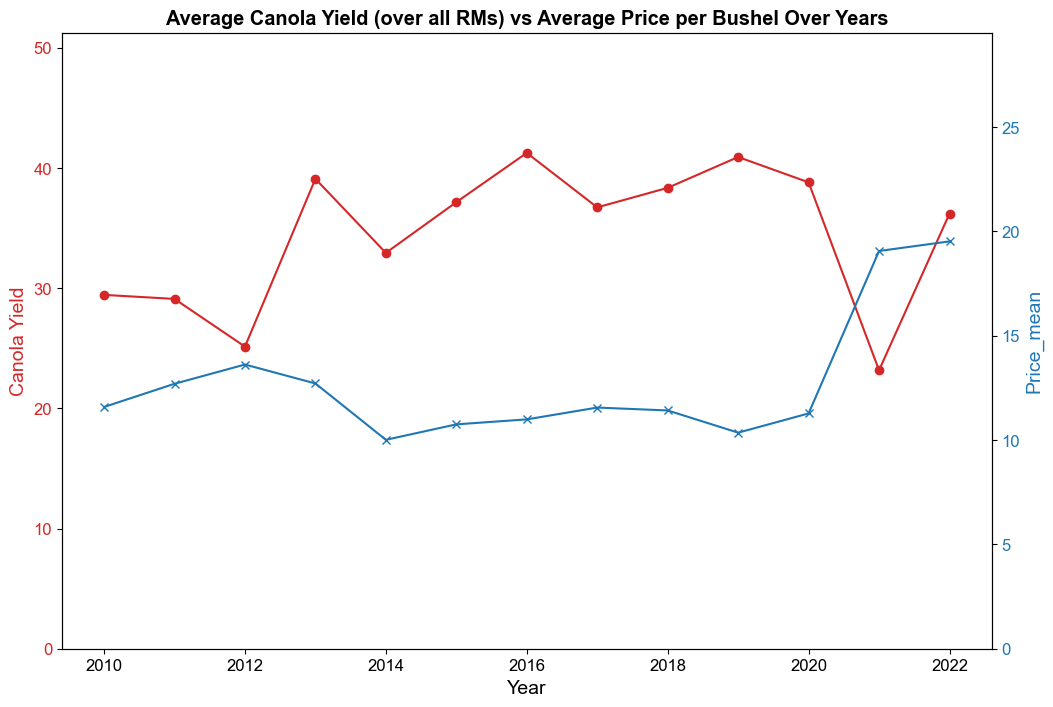

In [101]:
# Create the figure and the line plot for yield and price
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Canola Yield', color=color)
ax1.plot(df_value_agg_by_year['Year'], df_value_agg_by_year['Canola_mean'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Price_mean', color=color)
ax2.plot(df_value_agg_by_year['Year'], df_value_agg_by_year['Price_mean'], color=color, marker='x')
ax2.tick_params(axis='y', labelcolor=color)

# Set y-axis limits to start at zero for both axes
ax1.set_ylim(0, df_value_agg_by_year['Canola_mean'].max() + 10)  # Adjust the upper limit as needed
ax2.set_ylim(0, df_value_agg_by_year['Price_mean'].max() + 10)  # Adjust the upper limit as needed


# Show the plot
plt.title('Average Canola Yield (over all RMs) vs Average Price per Bushel Over Years')
plt.show()

## Calculating Yield vs Value (Top 10)

In [102]:
# top 10 Canola Yield over all years are? (recall NaN doesn't affect mean)
df_yield_value_year = df_data_merged.sort_values(['Year', 'RM']).dropna() # will drop rows with nulls for Value or Yield
# print(df_yield)
print(f"The df_yield_value_year DataFrame, which has had rows with null values in the 'Value' or 'Yield' columns dropped,\n spans from the minimum year of {df_yield_value_year['Year'].min()} to the maximum year of {df_yield_value_year['Year'].max()}.")
df_yield_value_year

The df_yield_value_year DataFrame, which has had rows with null values in the 'Value' or 'Yield' columns dropped,
 spans from the minimum year of 2010 to the maximum year of 2022.


,RM,Year,Canola,Value
2877,1,2010,27.600,319.74
3642,10,2010,27.300,316.27
7892,100,2010,26.800,310.48
7977,101,2010,26.200,303.52
8062,102,2010,34.300,397.36
...,...,...,...,...
2687,WHITEHEAD,2022,33.453,653.06
2716,WHITEMOUTH,2022,39.036,762.04
2744,WINNIPEG,2022,41.204,804.36
2774,WOODLANDS,2022,35.942,701.65


In [103]:
# Group by 'RM' and calculate the mean, mean of means, and std for 'Canola'
df_data_agg = df_yield_value_year.groupby('RM').agg(
    Canola_mean=('Canola', 'mean'),
    Canola_std=('Canola', 'std'),
    Value_mean=('Value', 'mean'),
    Value_std=('Value', 'std')
).reset_index()

# Round the calculated values to 3 decimal places
df_data_agg = df_data_agg.round({'Canola_mean': 3, 'Canola_std': 3, 'Value_mean': 3, 'Value_std': 3})

df_data_agg

,RM,Canola_mean,Canola_std,Value_mean,Value_std
0,1,31.342,6.882,401.699,145.267
1,10,26.241,7.441,333.429,118.325
2,100,34.815,7.561,445.460,161.423
3,101,28.982,5.627,368.375,114.470
4,102,35.533,7.614,441.851,94.378
...,...,...,...,...,...
386,WHITEHEAD,34.953,6.134,441.705,115.009
387,WHITEMOUTH,36.080,12.856,455.102,179.707
388,WINNIPEG,33.398,11.192,413.185,162.217
389,WOODLANDS,32.408,11.627,400.361,153.326


In [104]:
# Sort the result by 'Canola' in descending order and select the top 10 rows
df_top10_yield = df_data_agg.sort_values('Canola_mean', ascending=False).head(10)
df_top10_yield['Rank'] = range(1, len(df_top10_yield) + 1) # Add a 'Rank' column starting at 1
df_top10_yield

,RM,Canola_mean,Canola_std,Value_mean,Value_std,Rank
356,RHINELAND,44.687,7.208,564.825,148.398,1
110,271,44.572,9.911,566.433,191.948,2
328,HILLSBURG-ROBLIN-SHELL RIVER,44.524,8.866,561.917,171.380,3
335,LOUISE,44.277,6.704,554.761,111.715,4
376,SWAN VALLEY WEST,43.854,10.263,553.334,170.970,5
361,ROLAND,43.576,9.880,542.053,155.549,6
130,303,43.518,9.632,550.628,177.417,7
222,439,43.382,9.244,535.141,109.814,8
340,MONTCALM,43.030,6.444,544.912,141.354,9
310,DUFFERIN,42.760,8.629,535.205,143.565,10


In [105]:
# using this one for mapping so that we are comparing the same same period for yield vs value
df_top10_value = df_data_agg.sort_values('Value_mean', ascending=False).head(10)
df_top10_value['Rank'] = range(1, len(df_top10_value) + 1) # Add a 'Rank' column starting at 1
df_top10_value

# this is DIFFERENT than mean of Canola yields from all time or since 2002

,RM,Canola_mean,Canola_std,Value_mean,Value_std,Rank
355,REYNOLDS,36.552,11.190,629.820,313.026,1
110,271,44.572,9.911,566.433,191.948,2
356,RHINELAND,44.687,7.208,564.825,148.398,3
328,HILLSBURG-ROBLIN-SHELL RIVER,44.524,8.866,561.917,171.380,4
335,LOUISE,44.277,6.704,554.761,111.715,5
376,SWAN VALLEY WEST,43.854,10.263,553.334,170.970,6
130,303,43.518,9.632,550.628,177.417,7
340,MONTCALM,43.030,6.444,544.912,141.354,8
361,ROLAND,43.576,9.880,542.053,155.549,9
249,493,42.515,8.314,540.992,179.664,10


In [106]:
# Sort the result by 'Canola' in descending order and select the top 10 rows for ALL years
# df_top10_value = df_data_merged.loc[df_data_merged['Year'] > 2009].sort_values(['RM', 'Year'])
# df_top10_value = df_top10_value.drop(columns=['Year','Value']).groupby('RM').mean(numeric_only=True).sort_values('Canola', ascending=False).head(10)
df_all_top10_value = df_data_merged.sort_values(['RM', 'Year'])
df_all_top10_value = df_all_top10_value.drop(columns=['Year','Value']).groupby('RM').mean(numeric_only=True).sort_values('Canola', ascending=False).head(10)
df_all_top10_value

,Canola
RM,
VICTORIA,39.028867
LOUISE,38.565500
LORNE,38.009400
SWAN VALLEY WEST,37.991367
STANLEY,37.397033
RHINELAND,37.304800
ROLAND,37.247167
THOMPSON,37.230733
HILLSBURG-ROBLIN-SHELL RIVER,37.152400


In [107]:
# using our smallest amount of missing Canola values, the top 10 since 2002 are?
df_20yr_top10_yield = df_data_merged.loc[df_data_merged['Year'] > 2001].sort_values(['RM', 'Year'])
df_20yr_top10_yield = df_20yr_top10_yield.drop(columns=['Year','Value']).groupby('RM').mean(numeric_only=True).sort_values('Canola', ascending=False).head(10)
df_20yr_top10_yield

# this is DIFFERENT than mean of Canola yields from all time or since 2010

,Canola
RM,
SWAN VALLEY WEST,42.067429
LOUISE,41.668476
VICTORIA,41.131524
HILLSBURG-ROBLIN-SHELL RIVER,40.928143
LORNE,40.441048
ROLAND,40.362000
RHINELAND,40.183190
STANLEY,39.831857
DUFFERIN,39.705381


## Normalize Crop/Value Scaling

In [108]:
df_data_agg.shape

(391, 5)

In [109]:
df_data_agg.columns

Index(['RM', 'Canola_mean', 'Canola_std', 'Value_mean', 'Value_std'], dtype='object')

In [110]:
df_data_agg.head(10)

,RM,Canola_mean,Canola_std,Value_mean,Value_std
0,1,31.342,6.882,401.699,145.267
1,10,26.241,7.441,333.429,118.325
2,100,34.815,7.561,445.460,161.423
3,101,28.982,5.627,368.375,114.470
4,102,35.533,7.614,441.851,94.378
5,103,32.326,7.511,395.482,58.570
6,104,32.023,11.048,382.458,103.417
7,105,28.522,8.953,341.565,78.824
8,106,26.101,7.140,316.908,72.443
9,107,31.589,9.337,383.595,91.631


In [111]:
# df1_all_20yrs_group.shape

In [112]:
# df1_all_20yrs_group.columns

In [113]:
# # Let's only use the Canola Data from past 20 years to minimize missing values for mean
# # df_yield_20yrs = df_data_merged.loc[df_data_merged['Year'] > 2001].sort_values(['RM', 'Year'])
# # df_yield_20yrs.drop(columns=['Year']).groupby('RM').mean(numeric_only=True)

# df_all_20yrs = df_data_merged.loc[df_data_merged['Year'] > 2001].sort_values(['RM', 'Year'])

# #df_all_20yrs = df_data_merged.sort_values(['RM', 'Year'])
# #df_all_20yrs.drop(columns=['Year']).groupby('RM').mean(numeric_only=True)

# # Test for null values in the 'Canola' column
# null_canola_count = df_yield_value_year['Canola'].isnull().sum()

# # Check if there are any null values
# if null_canola_count > 0:
#     print(f"There are {null_canola_count} rows with null 'Canola' values, but not removed.")
    
#     # Remove rows with null 'Canola' values
#     #df_all_20yrs = df_all_20yrs.dropna(subset=['Canola'])

#     #print("Null 'Canola' rows have been removed.")
# else:
#     print("There are no null 'Canola' values.")

# df_all_20yrs

In [114]:
df_yield_value_year

,RM,Year,Canola,Value
2877,1,2010,27.600,319.74
3642,10,2010,27.300,316.27
7892,100,2010,26.800,310.48
7977,101,2010,26.200,303.52
8062,102,2010,34.300,397.36
...,...,...,...,...
2687,WHITEHEAD,2022,33.453,653.06
2716,WHITEMOUTH,2022,39.036,762.04
2744,WINNIPEG,2022,41.204,804.36
2774,WOODLANDS,2022,35.942,701.65


In [115]:
# df_all_20yrs_group = df_all_20yrs.drop(columns=['Year']).groupby('RM').mean(numeric_only=True)
# df_all_20yrs_group

In [116]:
# Standardize the necessary columns ('Canola' and 'Value')
# Initialize the Scaler
#scaler = RobustScaler()
#scaler = StandardScaler()
scaler = MinMaxScaler() # Changed to MinMax because the 0-1 scale was easier to visualize on the GIS maps.

# Columns to be considered for clustering
cluster_columns = ['Canola', 'Value']

df_yield_value_year_standardized = df_yield_value_year.copy()
df_yield_value_year_standardized[cluster_columns] = scaler.fit_transform(df_yield_value_year[cluster_columns])

# k-means also needs another copy
# df_yield_value_year_standardized_single = df_yield_value_year_standardized.copy()
# consider just replacing this name in the code below

In [117]:
df_yield_value_year_standardized
# we could have merged these into df_yield_value_year as _scaled columns 
# but k-Means analysis references thses by Canola/Value names

,RM,Year,Canola,Value
2877,1,2010,0.448047,0.265180
3642,10,2010,0.442817,0.261924
7892,100,2010,0.434100,0.256492
7977,101,2010,0.423640,0.249962
8062,102,2010,0.564854,0.338002
...,...,...,...,...
2687,WHITEHEAD,2022,0.550087,0.577898
2716,WHITEMOUTH,2022,0.647420,0.680142
2744,WINNIPEG,2022,0.685216,0.719847
2774,WOODLANDS,2022,0.593480,0.623485


Based on the boxplots:

Canola: The boxplot shows a relatively compact interquartile range (IQR) with a few potential outliers on the lower end. However, these outliers do not appear to be extreme and are fairly close to the box.

Value: The boxplot shows several points that could be considered as outliers, particularly on the higher end. The presence of these outliers might affect the scaling if a method sensitive to outliers is used.

Given these observations, the following scalers are recommended:

For Canola: A Min-Max Scaler could be suitable since the data does not show extreme outliers and is not normally distributed.

For Value: A Robust Scaler is recommended due to the presence of outliers. This scaler uses the median and the IQR, making it less sensitive to outliers.

Since we want to compare both, we will apply Robust Scaler to BOTH.

Unlike some other scaling techniques, such as Min-Max scaling or Z-score scaling (StandardScaler), the RobustScaler uses statistics that are resistant to the influence of outliers.

Key characteristics and advantages of the RobustScaler:

Robustness to Outliers: The RobustScaler is particularly useful when your dataset contains outliers, as it uses the median and IQR, which are not affected by extreme values.

Centering: It centers the data by subtracting the median, making the scaled data have a median of 0.

Scaling: It scales the data by dividing by the IQR, which helps maintain the relative spread of values.

No Assumption of Data Distribution: Unlike some scaling methods that assume a normal distribution, the RobustScaler is distribution-agnostic.

Output Range: The scaled values may vary widely depending on the distribution of the original data. There is no specific predefined output range like [0, 1] or [-1, 1]. The range depends on the spread of the data.

Preservation of Rank Order: The RobustScaler preserves the rank order of data points, which can be important in some algorithms.

Changed to MinMax because the 0-1 scale was easier to visualize on the GIS maps.

In [118]:
# this code block works but it is redundant
# no manual null tests required because 
# df_yield_value_year -> df_data_agg
# df_yield_value_year has .dropna which drops nulls

# Normalize Canola and Value so that we can compare them on GIS maps

# Initialize the Scaler
#scaler = RobustScaler()
#scaler = StandardScaler()
scaler = MinMaxScaler()

# Create masks to identify rows where 'Canola' and 'Value' are not NaN
canola_mask = ~df_data_agg['Canola_mean'].isna()
value_mask = ~df_data_agg['Value_mean'].isna()

# Select the 'Canola' and 'Value' columns for scaling
# Scale 'Canola' only if 'Value' is NaN but 'Canola' exists
df_to_scale_canola = df_data_agg.loc[canola_mask, ['Canola_mean']]
df_to_scale_value = df_data_agg.loc[value_mask, ['Value_mean']]

# Fit the scaler to the data and transform the selected columns
scaled_canola_values = scaler.fit_transform(df_to_scale_canola)
scaled_value_values = scaler.fit_transform(df_to_scale_value)

# Create DataFrames to store the scaled values
df_scaled_canola = pd.DataFrame(scaled_canola_values, columns=['Canola_Scaled'])
df_scaled_value = pd.DataFrame(scaled_value_values, columns=['Value_Scaled'])

# Merge the scaled values back into the original DataFrame, aligning them with the non-NaN rows
df_data_agg.loc[canola_mask, ['Canola_scaled']] = df_scaled_canola.values
df_data_agg.loc[value_mask, ['Value_scaled']] = df_scaled_value.values

# Show the first few rows of the updated DataFrame
df_data_agg

,RM,Canola_mean,Canola_std,Value_mean,Value_std,Canola_scaled,Value_scaled
0,1,31.342,6.882,401.699,145.267,0.521702,0.458187
1,10,26.241,7.441,333.429,118.325,0.338877,0.296039
2,100,34.815,7.561,445.460,161.423,0.646178,0.562125
3,101,28.982,5.627,368.375,114.470,0.437117,0.379039
4,102,35.533,7.614,441.851,94.378,0.671911,0.553553
...,...,...,...,...,...,...,...
386,WHITEHEAD,34.953,6.134,441.705,115.009,0.651124,0.553206
387,WHITEMOUTH,36.080,12.856,455.102,179.707,0.691516,0.585025
388,WINNIPEG,33.398,11.192,413.185,162.217,0.595391,0.485468
389,WOODLANDS,32.408,11.627,400.361,153.326,0.559908,0.455009


Why Scale? If we want to compare the map visualization of Canola vs Value they must have the same scale legend for the colours to be compared.

In [119]:
# export for analysis
# df_yield_value_year.to_csv(file_path + 'df_yield_value_year_output.csv', index=True)  # Export to CSV file without including the index

# EDA (Exploratory Data Analysis)

In [120]:
# Convert the 'RM' column to a string
df_data_merged['RM'] = df_data_merged['RM'].astype(str)

df_data_merged.dtypes

RM         object
Year        int64
Canola    float64
Value     float64
dtype: object

In [121]:
# Export the DataFrame to a CSV file
df_data_merged.to_csv(file_path + 'Data/df_data_merged_output.csv', index=False)  

In [122]:
df_data_merged

,RM,Year,Canola,Value
0,ALEXANDER,1993,11.067,NaN
1,ALEXANDER,1994,12.743,NaN
2,ALEXANDER,1995,27.337,NaN
3,ALEXANDER,1996,33.304,NaN
4,ALEXANDER,1997,28.719,NaN
...,...,...,...,...
28112,622,2018,39.300,448.77
28113,622,2019,46.100,477.36
28114,622,2020,40.900,461.19
28115,622,2021,23.900,455.56


In [123]:
df_data_merged.describe()

,Year,Canola,Value
count,28117.000000,17001.000000,4983.000000
mean,1982.646193,25.653906,431.122011
std,24.843729,9.894870,142.017517
min,1938.000000,0.000000,37.090000
25%,1961.000000,18.900000,342.140000
50%,1985.000000,24.339000,421.560000
75%,2004.000000,31.879000,492.470000
max,2022.000000,59.500000,1102.970000


In [124]:
#%pip install skimpy

In [125]:
# # Fancy describe function with boxes and more details
# from skimpy import skim

# #iris = sns.load_dataset(df_data_merged)
# #skim(iris)
# skim(df_data_merged)

In [126]:
# %pip install autoviz

In [127]:
# meant more for numerical regression datasets
# source: https://github.com/AutoViML/AutoViz

# from autoviz.AutoViz_Class import AutoViz_Class

# AV = AutoViz_Class()
# #AV.AutoViz(file_path + 'Data/df_data_merged_output.csv', depVar="Value")

# open html interactive charts
# dft = AV.AutoViz(
#     "",
#     sep=",",
#     depVar="",
#     dfte=df_data_merged,
#     header=0,
#     verbose=1,
#     lowess=False,
#     chart_format="server",
#     max_rows_analyzed=150000,
#     max_cols_analyzed=30,
#     save_plot_dir=None
# )

# # generate Bokeh charts in HTML
# dft = AV.AutoViz(
#     file_path + 'Data/df_data_merged_output.csv',
#     sep=",",
#     depVar="Value",
#     dfte=None,
#     header=0,
#     verbose=2,
#     lowess=False,
#     chart_format="bokeh",
#     max_rows_analyzed=150000,
#     max_cols_analyzed=30,
#     save_plot_dir=file_path + 'Visuals'
# )

In [128]:
print(f"Number of unique RMs values:", df_data_merged['RM'].nunique())

Number of unique RMs values: 397


In [129]:
print(f"The minimum year is {df_data_merged['Year'].min()} and the maximum year is {df_data_merged['Year'].max()}.")

The minimum year is 1938 and the maximum year is 2022.


## Missing Values

In [130]:
# Check for missing values in crop dataset
missing_values_count = df_data_merged.isnull().sum()
missing_values_count

RM            0
Year          0
Canola    11116
Value     23134
dtype: int64

In [131]:
# Check for missing values in stock price dataset
missing_values_count = df_price_merged.isnull().sum()
missing_values_count

RM         0
Year       0
Canola    77
Price      0
Value     77
dtype: int64

In [132]:
# Calculate the percentage of missing values for each column
missing_values_percentage = round((missing_values_count / len(df_data_merged)) * 100,0)
missing_values_percentage

RM        0.0
Year      0.0
Canola    0.0
Price     0.0
Value     0.0
dtype: float64

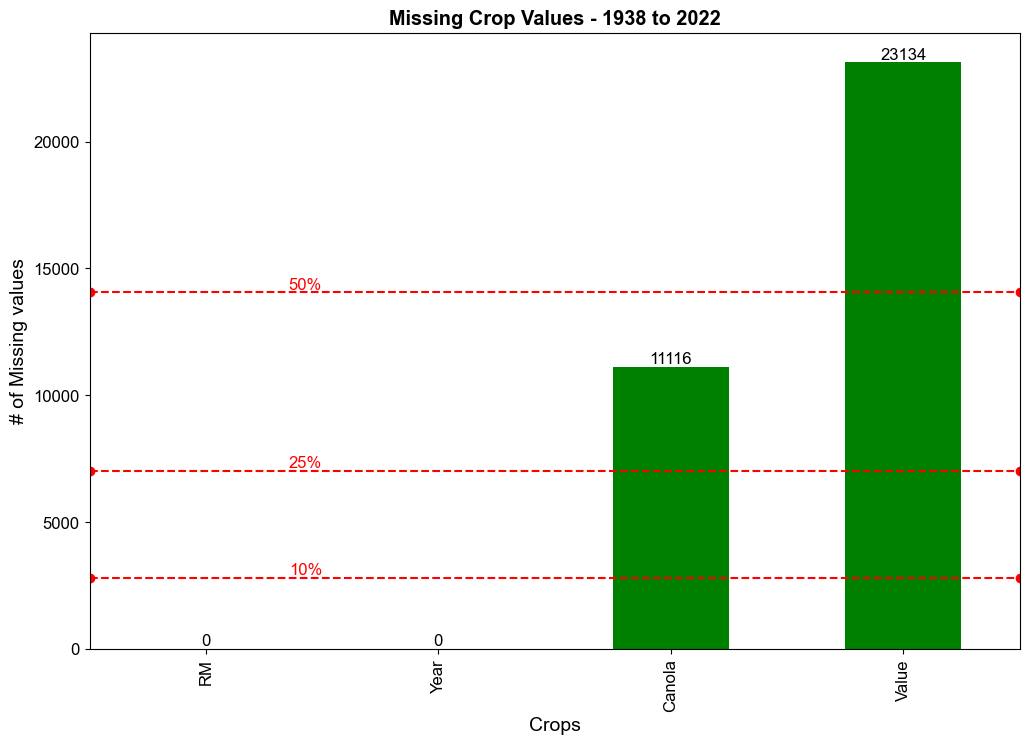

In [133]:
# Filter the DataFrame for ALL 'Year's and calculate missing values counts
missing_values_count_filtered = df_data_merged.isna().sum().sort_values()

# Get the minimum and maximum values of the missing values counts
y_min = missing_values_count_filtered.min()
y_max = missing_values_count_filtered.max()

# Plot the data with dynamic y-axis limits
ax = missing_values_count_filtered.plot(kind='bar', color='green')
ax.set_title('Missing Crop Values - 1938 to 2022')
ax.set_xlabel('Crops')
ax.set_ylabel('# of Missing values')

# Add actual values on top of each bar
for i, v in enumerate(missing_values_count_filtered):
    ax.text(i, v, str(v), color='black', va='bottom', ha='center')

# Calculate % of the total number of values
percent_value10 = len(df_data_merged) * 0.1
percent_value25 = len(df_data_merged) * 0.25
percent_value50 = len(df_data_merged) * 0.5

# Plot a horizontal dashed line at %
plt.axhline(percent_value10, linestyle='--', color='red', label='10% of values')
plt.axhline(percent_value25, linestyle='--', color='red', label='25% of values')
plt.axhline(percent_value50, linestyle='--', color='red', label='50% of values')

# Add a text label next to the line
plt.text(0.5, percent_value10, '10%', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.text(0.5, percent_value25, '25%', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.text(0.5, percent_value50, '50%', color='red', verticalalignment='bottom', horizontalalignment='right')

plt.show()

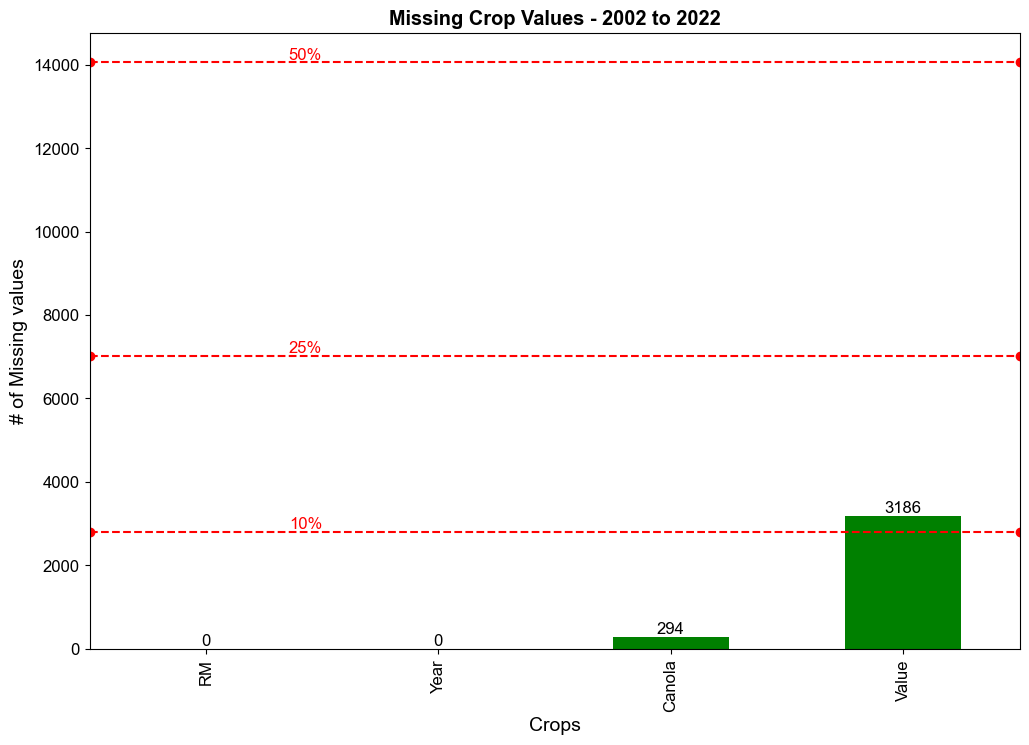

In [134]:
# minimal Canola missing yields is since 2002
missing_values = df_data_merged.loc[df_data_merged['Year']>2001].isna().sum().sort_values()
ax = missing_values.plot(kind='bar', color='green')

# Add actual values on top of each bar
for i, v in enumerate(missing_values):
    ax.text(i, v, str(v), color='black', va='bottom', ha='center')

plt.title('Missing Crop Values - 2002 to 2022')
plt.xlabel('Crops')
plt.ylabel('# of Missing values')

# Calculate % of the total number of values
percent_value10 = len(df_data_merged) * 0.1
percent_value25 = len(df_data_merged) * 0.25
percent_value50 = len(df_data_merged) * 0.5

# Plot a horizontal dashed line at %
plt.axhline(percent_value10, linestyle='--', color='red', label='10% of values')
plt.axhline(percent_value25, linestyle='--', color='red', label='25% of values')
plt.axhline(percent_value50, linestyle='--', color='red', label='50% of values')

# Add a text label next to the line
plt.text(0.5, percent_value10, '10%', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.text(0.5, percent_value25, '25%', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.text(0.5, percent_value50, '50%', color='red', verticalalignment='bottom', horizontalalignment='right')

plt.show()

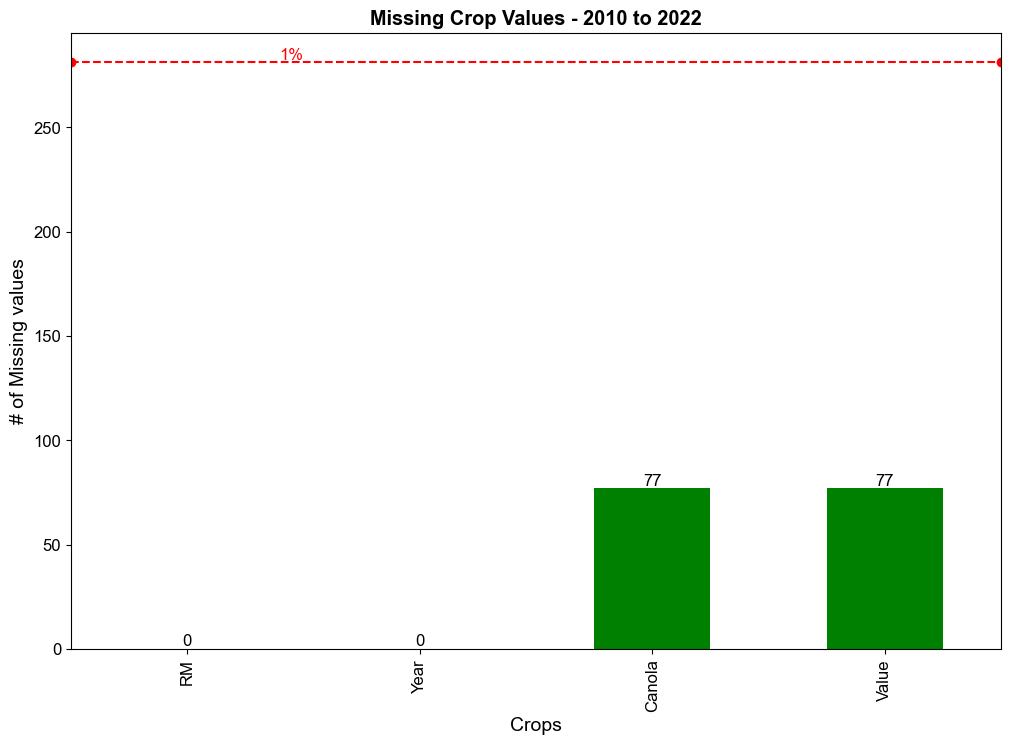

In [135]:
# minimal Canola missing stock prices is since 2010
missing_values = df_data_merged.loc[df_data_merged['Year'] > 2009].isna().sum().sort_values()
ax = missing_values.plot(kind='bar', color='green')

# Add actual values on top of each bar
for i, v in enumerate(missing_values):
    ax.text(i, v, str(v), color='black', va='bottom', ha='center')
plt.title('Missing Crop Values - 2010 to 2022')
plt.xlabel('Crops')
plt.ylabel('# of Missing values')
# Calculate % of the total number of values
one_percent_value = len(df_data_merged) * 0.01

# Plot a horizontal dashed line at %
plt.axhline(one_percent_value, linestyle='--', color='red', label='1% of values')

# Add a text label next to the line
plt.text(0.5, one_percent_value, '1%', color='red', verticalalignment='bottom', horizontalalignment='right')

plt.show()


In [136]:
# Select rows where 'Year' is greater than 2001 and then calculate missing values counts
missing_values_count = df_data_merged[df_data_merged['Year'] > 2001].isnull().sum()

# Display the missing values counts
missing_values_count


RM           0
Year         0
Canola     294
Value     3186
dtype: int64

#### This helps illustrate if we utilize only the last 20 years (since 2002) there is a marked decrease is missing values for YIELD, or since 2010 for YIELD and VALUE (important for calculation median or std).

## Outlier Detection

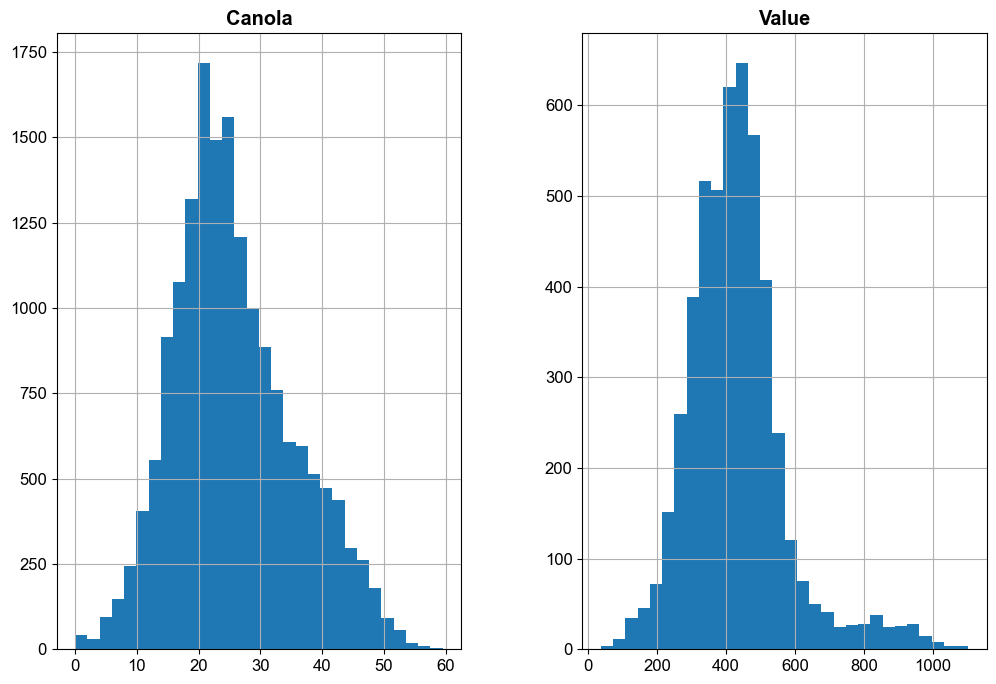

In [137]:
numerical_columns = df_data_merged.select_dtypes(include='number').drop(columns=['Year']).columns
# view distributions
df_data_merged[numerical_columns].hist(bins=30)
plt.show()

### Boxplots

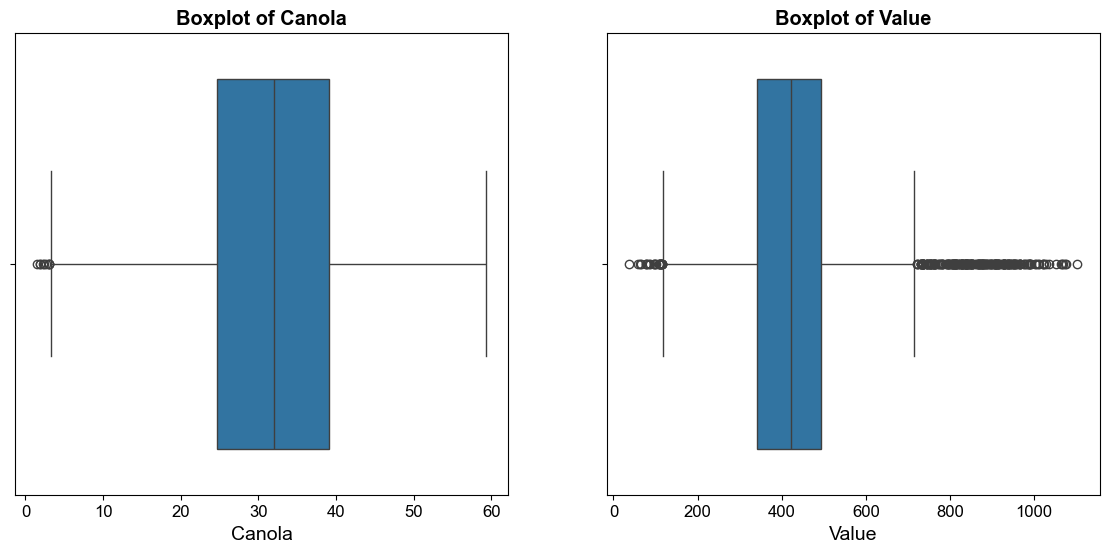

In [138]:
# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the distribution of the "Canola" column
sns.boxplot(x=df_data_merged.loc[df_data_merged['Year'] > 2001]['Canola'], ax=axes[0])
axes[0].set_title('Boxplot of Canola')

# Plot the distribution of the "Value" column (ignoring NaN values for the plot)
sns.boxplot(x=df_data_merged.loc[df_data_merged['Year'] > 2001]['Value'].dropna(), ax=axes[1])
axes[1].set_title('Boxplot of Value')

# Show the plots
plt.show()

<Axes: >

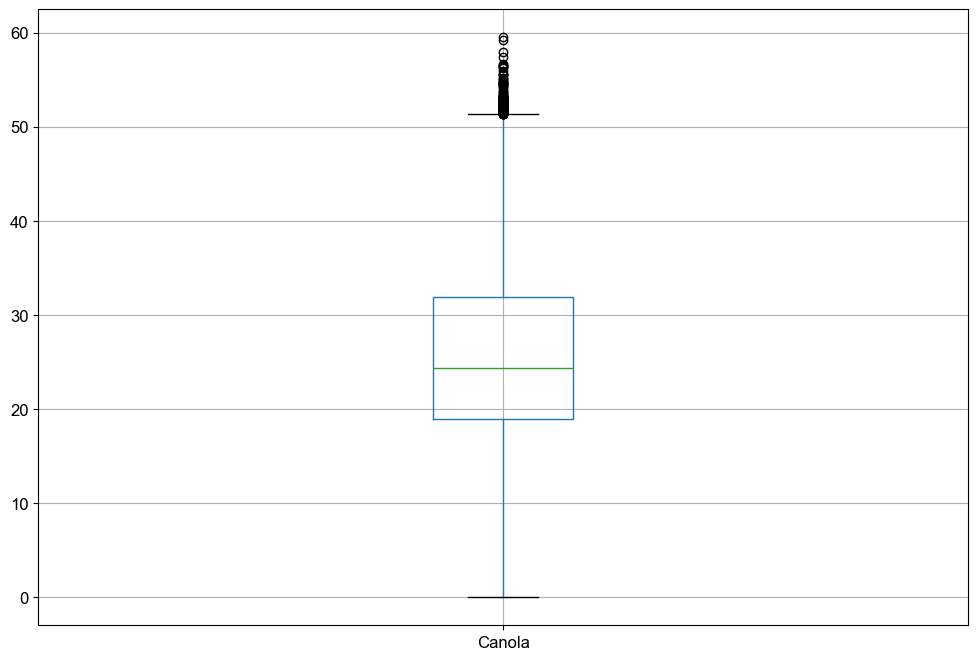

In [139]:
df_data_merged[target_crop].boxplot()

In [140]:
df_data_merged.head()

,RM,Year,Canola,Value
0,ALEXANDER,1993,11.067,NaN
1,ALEXANDER,1994,12.743,NaN
2,ALEXANDER,1995,27.337,NaN
3,ALEXANDER,1996,33.304,NaN
4,ALEXANDER,1997,28.719,NaN


In [273]:
df_yield_value_year

,RM,Year,Canola,Value,Cluster,Cluster_k2,DBSCAN_Cluster_Optimal
2877,1,2010,27.600,319.74,0,0,0
3642,10,2010,27.300,316.27,0,0,0
7892,100,2010,26.800,310.48,0,0,0
7977,101,2010,26.200,303.52,0,0,0
8062,102,2010,34.300,397.36,2,0,0
...,...,...,...,...,...,...,...
2687,WHITEHEAD,2022,33.453,653.06,1,1,0
2716,WHITEMOUTH,2022,39.036,762.04,3,1,0
2744,WINNIPEG,2022,41.204,804.36,3,1,0
2774,WOODLANDS,2022,35.942,701.65,3,1,0


In [274]:
# another correlation visualization with more specific focus
numerical_columns = df_yield_value_year.select_dtypes(include='number').columns  # Use square brackets [] to access columns
# Show all correlation values
df_corr = df_yield_value_year[numerical_columns].corr().round(1)

#df_corr = corr_df.round(1)
# Mask to matrix
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Viz
df_corr_viz = df_corr.mask(mask).dropna(how='all').dropna(how='all')
# colour variable https://plotly.com/python/colorscales/
fig = px.imshow(df_corr_viz, text_auto=True, color_continuous_scale=[(0.00, "black"),   (0.33, "black"),
                                                     (0.33, "white"), (0.66, "white"),
                                                     (0.66, "blue"),  (1.00, "blue")])
# unable to write to image, simply take screenshot
fig.show()

In [141]:
# another correlation visualization with more specific focus
numerical_columns = df_price_merged.select_dtypes(include='number').columns  # Use square brackets [] to access columns
# Show all correlation values
df_corr = df_price_merged[numerical_columns].corr().round(1)

#df_corr = corr_df.round(1)
# Mask to matrix
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Viz
df_corr_viz = df_corr.mask(mask).dropna(how='all').dropna(how='all')
# colour variable https://plotly.com/python/colorscales/
fig = px.imshow(df_corr_viz, text_auto=True, color_continuous_scale=[(0.00, "black"),   (0.33, "black"),
                                                     (0.33, "white"), (0.66, "white"),
                                                     (0.66, "blue"),  (1.00, "blue")])
# unable to write to image, simply take screenshot
fig.show()

# Visualizations

## GIS Visualization

In [142]:
df_gdf.shape # should be 27909,12 with SK and MB

(27909, 5)

In [143]:
if show_maps:
# why won't this print when True?
# show all RM shapefiles
# Create a Folium Map centered on the data
    m = folium.Map(location=[gdf.centroid.y.mean(), gdf.centroid.x.mean()], zoom_start=8)

    # Add GeoJSON data (your GeoDataFrame) with only borders and no color
    for idx, row in gdf.iterrows():
        folium.GeoJson(row.geometry.__geo_interface__,
                    style_function=lambda x: {'color': 'blue', 'weight': 1},
                    ).add_to(m)

    # Display the map
    m

### Explore GIS Data

In [144]:
print(df_gdf.loc[df_gdf['Year'] == 2020].shape) # should be 391,12

(391, 5)


In [145]:
# what year has the most RM's ?
df_gdf.groupby('Year')['RM'].nunique().sort_values(ascending=False).head(5)

Year
2020    391
2000    391
2003    390
2010    390
1996    390
Name: RM, dtype: int64

In [146]:
# # quick test plot
# subset = df_gdf.loc[df_gdf['Year'] == 2020]
# subset.plot()

In [147]:
# quick and simple plot with legend but only 1 year
# df_gdf.loc[df_gdf['Year']==2020].plot(column='Canola',
#                                  legend=True,
#                                  cmap='Greens')

In [148]:
# export graph to html for interactivity for 1 year of Canola
# m=df_gdf.loc[df_gdf['Year']==2021].explore(column='Canola',
#                                  legend=True,
#                                  cmap='Greens',
#                                  tooltip= ['Canola', 'RM'],
#                                  tiles='Stamen Toner') # Plot() is good for showing up in GitHub, Explore() is good for interactive map and saving as HTML

# # Adding a title with dark orange color to the folium map
# title_html = '''
#                  <h3 align="center" style="font-size:30px; color:Blue;"><b> Canola Yield in 2021 </b></h3>
#              '''
# m.get_root().html.add_child(folium.Element(title_html))
# m.save(file_path + 'Visuals/Canola_2021.html')

#### Mass - Canola Yields

In [149]:
# Convert the DataFrame to GeoJSON format
# geo_json_data = json.loads(ds.to_json()) # takes 5 minutes

In [331]:
# view multiple years where Yield and Value exist and are standardized
if show_maps:
    # Get unique years
    unique_years = sorted(df_yield_value_year_standardized['Year'].dropna().unique())

    # Minimum value of the 'Canola' column
    global_min = df_yield_value_year_standardized['Canola'].min()

    # Maximum value of the 'Canola' column
    global_max = df_yield_value_year_standardized['Canola'].max()

    # Include Polygons
    gdf_yield_value_year_standardized = gpd.GeoDataFrame(df_yield_value_year_standardized.merge(gdf, on='RM'))

    # Create subplots
    n_years = len(unique_years)
    n_cols = 3  # Number of columns for subplots
    n_rows = int(n_years / n_cols) + (n_years % n_cols > 0)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))

    # Flatten the axes array and remove extra subplots
    axes = axes.flatten()
    for ax in axes[n_years:]:
        ax.remove()

    # Plot data for each year
    for year, ax in zip(unique_years, axes):
        #df_gdf[df_gdf['Year'] == year].plot(column='Canola',
        gdf_yield_value_year_standardized[gdf_yield_value_year_standardized['Year'] == year].plot(column='Canola',
                                    legend=False,
                                    cmap='Greens',
                                    ax=ax,
                                    vmin=global_min,  # Set min value for the colormap
                                    vmax=global_max)  # Set max value for the colormap
        ax.set_title(f'Canola Yield in {year}')

        # Hide x and y-axis labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

    # Create a common legend for all subplots
    fig.subplots_adjust(right=0.8, hspace=0.4, wspace=0.4)
    cax = fig.add_axes([0.85, 0.2, 0.03, 0.6])
    sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=global_min, vmax=global_max))
    sm.set_array([])
    fig.colorbar(sm, cax=cax)

    # Adjust the layout manually
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.8, hspace=0.4, wspace=0.4)

    plt.show()

In [330]:
# display mass Canola yield maps but from original values 
if show_maps:
    # Get unique years
    unique_years = sorted(df_gdf['Year'].dropna().unique())
    # Get the last years from the sorted unique_years list
    unique_years = unique_years[-21:]

    # Get global min and max values for 'Canola' for the last years, ensures all charts have the same scale
    global_min = df_gdf[df_gdf['Year'].isin(unique_years)]['Canola'].min()
    global_max = df_gdf[df_gdf['Year'].isin(unique_years)]['Canola'].max()

    # Create subplots
    n_years = len(unique_years)
    n_cols = 3  # Number of columns for subplots
    n_rows = int(n_years / n_cols) + (n_years % n_cols > 0)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))

    # Flatten the axes array and remove extra subplots
    axes = axes.flatten()
    for ax in axes[n_years:]:
        ax.remove()

    # Plot data for each year
    for year, ax in zip(unique_years, axes):
        df_gdf[df_gdf['Year'] == year].plot(column='Canola',
                                    legend=False,
                                    cmap='Greens',
                                    ax=ax,
                                    vmin=global_min,  # Set min value for the colormap
                                    vmax=global_max)  # Set max value for the colormap
        ax.set_title(f'Canola Yield in {year}')

        # Hide x and y-axis labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

    # Create a common legend for all subplots
    fig.subplots_adjust(right=0.8, hspace=0.4, wspace=0.4)
    cax = fig.add_axes([0.85, 0.2, 0.03, 0.6])
    sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=global_min, vmax=global_max))
    sm.set_array([])
    fig.colorbar(sm, cax=cax)

    # Adjust the layout manually
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.8, hspace=0.4, wspace=0.4)

    plt.show()


#### Mass - Canola Values

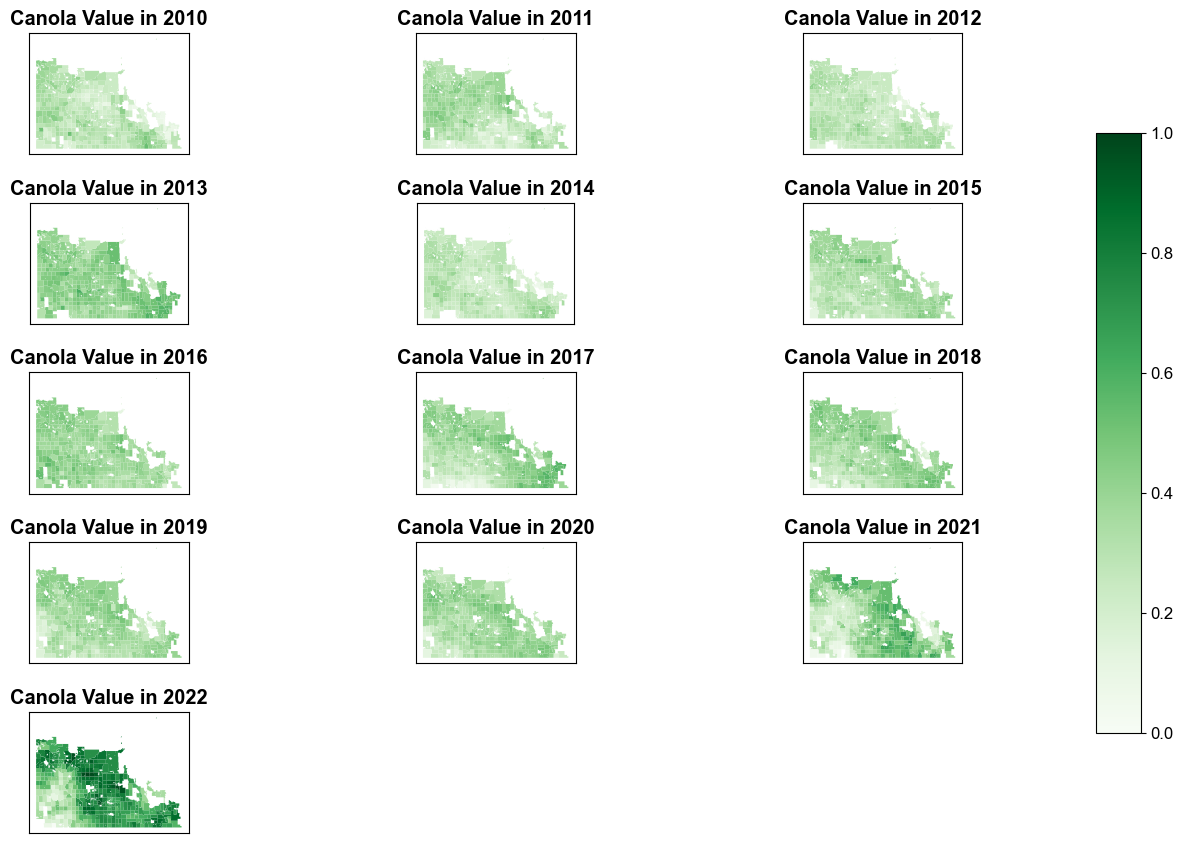

In [334]:
# Get unique years
unique_years = sorted(df_yield_value_year_standardized['Year'].dropna().unique())

# Minimum value of the 'Value' column
global_min = df_yield_value_year_standardized['Value'].min()

# Maximum value of the 'Value' column
global_max = df_yield_value_year_standardized['Value'].max()

# Include Polygons
gdf_yield_value_year_standardized = gpd.GeoDataFrame(df_yield_value_year_standardized.merge(gdf, on='RM'))

# Create subplots
n_years = len(unique_years)
n_cols = 3  # Number of columns for subplots
n_rows = int(n_years / n_cols) + (n_years % n_cols > 0)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))

# Flatten the axes array and remove extra subplots
axes = axes.flatten()
for ax in axes[n_years:]:
    ax.remove()

# Plot data for each year
for year, ax in zip(unique_years, axes):
    gdf_yield_value_year_standardized[gdf_yield_value_year_standardized['Year'] == year].plot(column='Value',
                                legend=False,
                                cmap='Greens',
                                ax=ax,
                                vmin=global_min,  # Set min value for the colormap
                                vmax=global_max)  # Set max value for the colormap
    ax.set_title(f'Canola Value in {year}')

    # Hide x and y-axis labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

# Create a common legend for all subplots
fig.subplots_adjust(right=0.8, hspace=0.4, wspace=0.4)
cax = fig.add_axes([0.85, 0.2, 0.03, 0.6])
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=global_min, vmax=global_max))
sm.set_array([])
fig.colorbar(sm, cax=cax)

# Adjust the layout manually
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.8, hspace=0.4, wspace=0.4)

plt.show()

In [340]:
if show_maps:
    # Get unique years
    # unique_years = sorted(df_gdf['Year'].dropna().unique())
    unique_years = sorted(df_gdf.dropna(subset=['Value'])['Year'].unique())

    # Get global min and max values for 'Canola' for the last years, ensures all charts have the same scale
    global_min = df_gdf[df_gdf['Year'].isin(unique_years)]['Value'].min()
    global_max = df_gdf[df_gdf['Year'].isin(unique_years)]['Value'].max()

    # Create subplots
    n_years = len(unique_years)
    n_cols = 3  # Number of columns for subplots
    n_rows = int(n_years / n_cols) + (n_years % n_cols > 0)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))

    # Flatten the axes array and remove extra subplots
    axes = axes.flatten()
    for ax in axes[n_years:]:
        ax.remove()

    # Plot data for each year
    for year, ax in zip(unique_years, axes):
        df_gdf[df_gdf['Year'] == year].plot(column='Value',
                                    legend=False,
                                    cmap='Greens',
                                    ax=ax,
                                    vmin=global_min,  # Set min value for the colormap
                                    vmax=global_max)  # Set max value for the colormap
        ax.set_title(f'Canola Valuation in {year}')

        # Hide x and y-axis labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

    # Create a common legend for all subplots
    fig.subplots_adjust(right=0.8, hspace=0.4, wspace=0.4)
    cax = fig.add_axes([0.85, 0.2, 0.03, 0.6])
    sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=global_min, vmax=global_max))
    sm.set_array([])
    fig.colorbar(sm, cax=cax)

    # Adjust the layout manually
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.8, hspace=0.4, wspace=0.4)

    plt.show()


In [341]:
if show_maps:
    # Get unique years
    # unique_years = sorted(df_gdf['Year'].dropna().unique())
    # unique_years = unique_years[-21:]
    # unique_years = sorted(df_gdf['Year'].dropna().unique())
    unique_years = sorted(df_gdf.dropna(subset=['Value'])['Year'].unique())


    # Get global min and max values for 'Canola' for the last years, ensures all charts have the same scale
    global_min = df_gdf[df_gdf['Year'].isin(unique_years)]['Value'].min()
    global_max = df_gdf[df_gdf['Year'].isin(unique_years)]['Value'].max()

    # Create subplots
    n_years = len(unique_years)
    n_cols = 3  # Number of columns for subplots
    n_rows = int(n_years / n_cols) + (n_years % n_cols > 0)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))

    # Flatten the axes array and remove extra subplots
    axes = axes.flatten()
    for ax in axes[n_years:]:
        ax.remove()

    # Plot data for each year
    for year, ax in zip(unique_years, axes):
        df_gdf[df_gdf['Year'] == year].plot(column='Value',
                                    legend=False,
                                    cmap='Greens',
                                    ax=ax,
                                    vmin=global_min,  # Set min value for the colormap
                                    vmax=global_max)  # Set max value for the colormap
        ax.set_title(f'Canola Valuation in {year}')

        # Hide x and y-axis labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

    # Create a common legend for all subplots
    fig.subplots_adjust(right=0.8, hspace=0.4, wspace=0.4)
    cax = fig.add_axes([0.85, 0.2, 0.03, 0.6])
    sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=global_min, vmax=global_max))
    sm.set_array([])
    fig.colorbar(sm, cax=cax)

    # Adjust the layout manually
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.8, hspace=0.4, wspace=0.4)

    plt.show()

#### Jointplot Yield vs Value

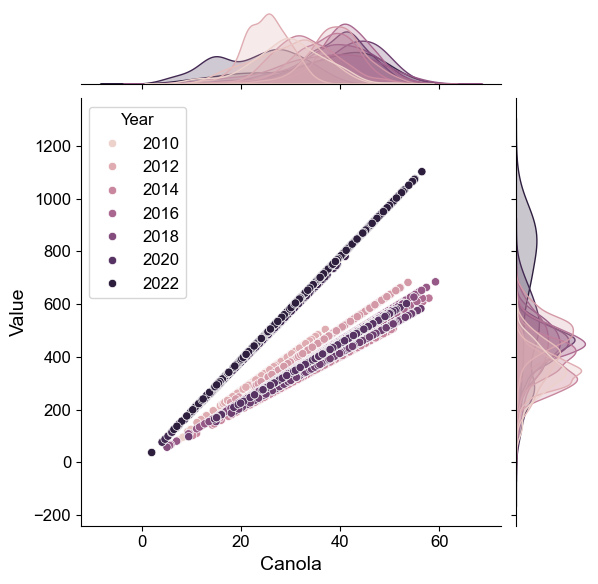

In [346]:
# Create a jointplot
sns.jointplot(data=df_yield_value_year, x='Canola', y='Value', hue='Year')

# Show the plot
plt.show()

In [152]:
# sample 
# sns.jointplot(data=df, x="flipper_length_mm",y="bill_length_mm",'hue="species")
# plt.show()

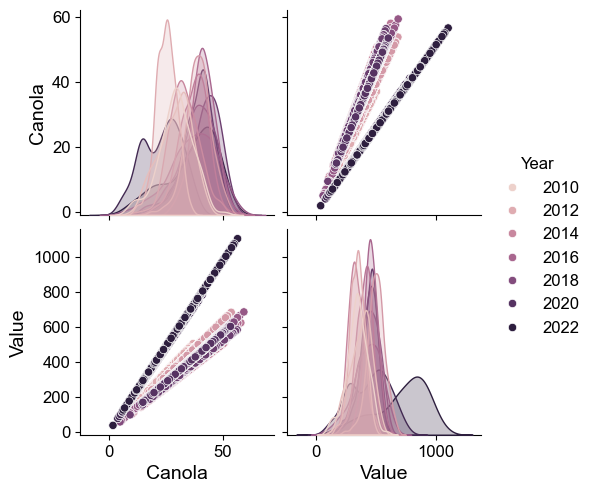

In [352]:
# Create a pairplot
sns.pairplot(data=df_yield_value_year, vars=['Canola', 'Value'], hue='Year')

# Show the plot
plt.show()


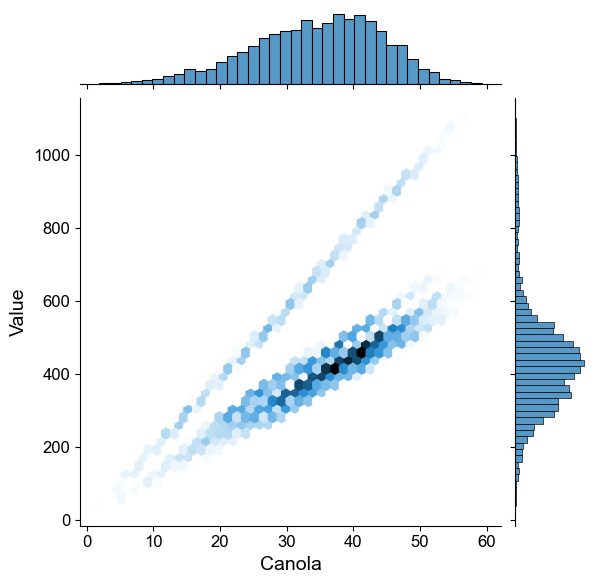

In [351]:
# Create a hexbin plot
sns.jointplot(data=df_yield_value_year, x='Canola', y='Value', kind='hex')

# Show the plot
plt.show()


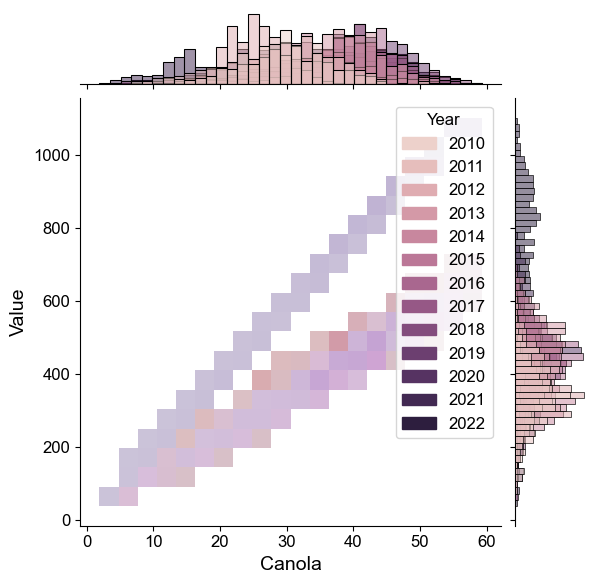

In [349]:
# Create a 2D histogram
sns.jointplot(data=df_yield_value_year, x='Canola', y='Value', hue='Year', kind='hist', bins=20, kde=True)

# Show the plot
plt.show()


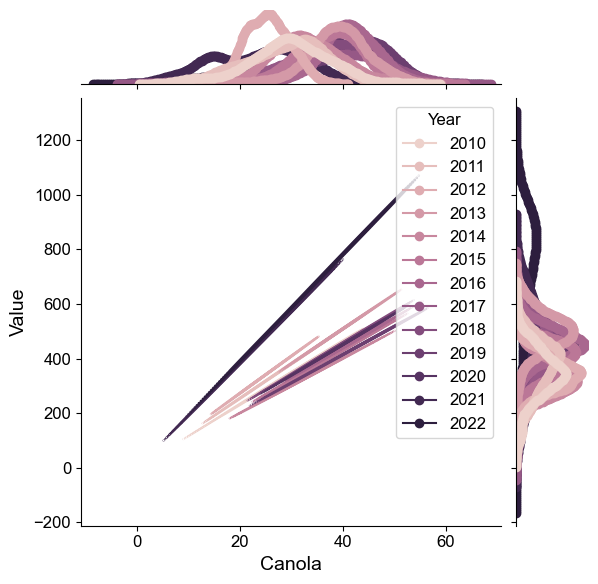

In [348]:
# Create a KDE plot
sns.jointplot(data=df_yield_value_year, x='Canola', y='Value', hue='Year', kind='kde')

# Show the plot
plt.show()


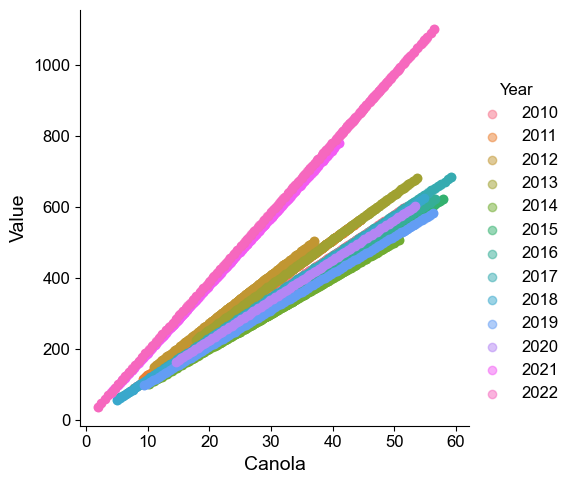

In [347]:
# Create a regression plot
sns.lmplot(data=df_yield_value_year, x='Canola', y='Value', hue='Year', scatter_kws={'alpha':0.5})

# Show the plot
plt.show()


## Canola RMs
.explore FAILS to display inside an if loop

### Canola RM's by Average Yield

In [153]:
if show_maps:
    # Merge the GeoDataFrame with the DataFrame containing the 'Canola' mean
    gdf_merged = pd.merge(
        gdf,
        df_data_agg,
        on='RM'
    )

    # Round the 'Canola' mean to 3 decimals
    gdf_merged['Canola_mean'] = gdf_merged['Canola_mean'].round(3)
    gdf_merged['Value_mean'] = gdf_merged['Value_mean'].round(3)


    # Create the map using .plot
    ax = gdf_merged.plot(
        column='Canola_scaled',  # The column to visualize
        cmap='RdYlGn',  # Choose a colormap
        legend=True  # Display a legend
    )

    # Display the map
    plt.show()


In [154]:
# # map doesn't show even if show_maps is true, need to copy and paste manually if you want to see
# # but do not save that way = file size grows like crazy
# # quick code to display map but no control over rounding mean
# pd.merge(
#     gdf,
#     df_all_20yrs_group,
#     on='RM').explore(
#         column='Canola_scaled',
#         cmap='RdYlGn')

In [155]:
# # Merge the GeoDataFrame with the DataFrame containing the 'Canola' mean
# gdf_merged = pd.merge(
#     gdf,
#     df_all_20yrs.drop(columns=['Year']).groupby('RM').mean(numeric_only=True),
#     on='RM'
# )

# # Round the 'Canola' mean to 3 decimals
# gdf_merged['Canola'] = gdf_merged['Canola'].round(3)
# gdf_merged['Value'] = gdf_merged['Value'].round(3)

# # Create the map
# m = gdf_merged.explore(
#     column='Canola',  # The column to visualize
#     cmap='RdYlGn'  # Choose a colormap
# )
# m

In [156]:
# this will never display (.explore inside IF??)
if show_maps:
    # display average canola yield std
    pd.merge(
        gdf,
        df_data_agg,
        on='RM').explore(
            column='Canola_mean',
            cmap='RdYlGn_r')

In [157]:
# EXPORT above GIS .explore to HTML
# this is required for both all_yields.html and all_value.html

# Merge df_all_20yrs with gdf to get the geometry
#gdf_yield = gdf.merge(df_all_20yrs.drop(columns=['Year']).groupby('RM').mean(numeric_only=True), left_on='RM', right_index=True)
#gdf_all_yields = gdf.merge(df_all_20yrs.drop(columns=['Year']).groupby('RM').mean(numeric_only=True), left_on='RM', right_index=True)
#gdf_all_yields = gdf.merge(df_data_agg, left_on='RM', right_index=True)
gdf_all_yields = gdf.merge(df_data_agg, on='RM')


In [158]:
gdf_all_yields.sort_values(by='RM')

,RM,geometry,Canola_mean,Canola_std,Value_mean,Value_std,Canola_scaled,Value_scaled
34,1,"POLYGON ((-101.39218 49.18548, -101.39223 49.1...",31.342,6.882,401.699,145.267,0.521702,0.458187
12,10,"POLYGON ((-104.81097 49.06477, -104.81097 49.0...",26.241,7.441,333.429,118.325,0.338877,0.296039
94,100,"POLYGON ((-105.25475 50.04683, -105.25470 50.0...",34.815,7.561,445.460,161.423,0.646178,0.562125
59,101,"POLYGON ((-105.61946 50.04680, -105.61823 50.0...",28.982,5.627,368.375,114.470,0.437117,0.379039
119,102,"POLYGON ((-105.69176 49.94815, -105.69177 49.9...",35.533,7.614,441.851,94.378,0.671911,0.553553
...,...,...,...,...,...,...,...,...
358,WHITEHEAD,"POLYGON ((-100.46277 49.88662, -100.46235 49.8...",34.953,6.134,441.705,115.009,0.651124,0.553206
350,WHITEMOUTH,"POLYGON ((-96.02118 50.11898, -96.02070 50.118...",36.080,12.856,455.102,179.707,0.691516,0.585025
363,WINNIPEG,"POLYGON ((-97.18411 49.97560, -97.18369 49.975...",33.398,11.192,413.185,162.217,0.595391,0.485468
377,WOODLANDS,"POLYGON ((-97.45990 50.41850, -97.45980 50.411...",32.408,11.627,400.361,153.326,0.559908,0.455009


In [159]:
# create HTML of Canola crop YIELDS
if show_maps:
    # Calculate the minimum and maximum years
    min_year = df_yield_value_year['Year'].min()
    max_year = df_yield_value_year['Year'].max()

    # Modify the GeoDataFrame to create a custom tooltip column
    gdf_all_yields['tooltip'] = '<br>RM: ' + gdf_all_yields['RM'] + '<br>Canola Yield: ' + gdf_all_yields['Canola_mean'].astype(str) + ' bushels<br>Value: $ ' + gdf_all_yields['Value_mean'].astype(str) + ' (Price x bushels)'

    # Create the map
    m = gdf_all_yields.explore(column='Canola_scaled',
                        legend=True,
                        cmap='Greens',
                        tooltip='tooltip',
                        tiles='Stamen Toner')

    # Adding a title with dynamic years
    title_html = f'''
                <h3 align="center" style="font-size:30px; color:Blue;"><b> All Canola Yield from {min_year}-{max_year} </b></h3>
                '''
    m.get_root().html.add_child(folium.Element(title_html))
    m.save(file_path + 'Visuals/Canola_AllYields.html')

### Top 10 Canola Average Yield

In [160]:
# Best Canola Average Yield
df_top10_yield

,RM,Canola_mean,Canola_std,Value_mean,Value_std,Rank
356,RHINELAND,44.687,7.208,564.825,148.398,1
110,271,44.572,9.911,566.433,191.948,2
328,HILLSBURG-ROBLIN-SHELL RIVER,44.524,8.866,561.917,171.380,3
335,LOUISE,44.277,6.704,554.761,111.715,4
376,SWAN VALLEY WEST,43.854,10.263,553.334,170.970,5
361,ROLAND,43.576,9.880,542.053,155.549,6
130,303,43.518,9.632,550.628,177.417,7
222,439,43.382,9.244,535.141,109.814,8
340,MONTCALM,43.030,6.444,544.912,141.354,9
310,DUFFERIN,42.760,8.629,535.205,143.565,10


In [161]:
if show_maps:
    # Merge the GeoDataFrame with df_top10_yield
    gdf_merged = pd.merge(
        gdf,
        df_top10_yield,
        on='RM'
    )

    # Create the map using .plot
    ax = gdf_merged.plot(
        column='Canola_mean',  # The column to visualize
        legend=True,  # Display a legend
        scheme='quantiles',  # Choose a color scheme
        cmap='cool'  # Choose a colormap
    )

    # Display the map
    plt.show()

In [162]:
# Top 10 Canola locations by yield interactive map
# pd.merge(
#     gdf,
#     df_top10_yield,
#     on='RM').explore(column='Canola_mean', legend='True', scheme='quantiles', cmap='cool')

In [163]:
# this will never display (.explore inside IF??)
if show_maps:
    pd.merge(
        gdf,
        df_top10_yield,
        on='RM').explore(column='Canola_mean', legend='True', scheme='quantiles', cmap='cool')

In [164]:
gdf_top10_yield = pd.merge(
        gdf,
        df_top10_yield,
        on='RM')

In [165]:
gdf_top10_yield.sort_values(by='Canola_mean', ascending=False)

,RM,geometry,Canola_mean,Canola_std,Value_mean,Value_std,Rank
9,RHINELAND,"POLYGON ((-97.45988 49.17636, -97.45988 49.170...",44.687,7.208,564.825,148.398,1
2,271,"MULTIPOLYGON (((-101.57052 51.65479, -101.5705...",44.572,9.911,566.433,191.948,2
3,HILLSBURG-ROBLIN-SHELL RIVER,"POLYGON ((-101.38880 51.62136, -101.37722 51.6...",44.524,8.866,561.917,171.380,3
4,LOUISE,"POLYGON ((-98.81757 49.33984, -98.81757 49.339...",44.277,6.704,554.761,111.715,4
5,SWAN VALLEY WEST,"POLYGON ((-101.31150 52.31802, -101.29991 52.3...",43.854,10.263,553.334,170.970,5
6,ROLAND,"POLYGON ((-97.73078 49.44359, -97.73076 49.436...",43.576,9.880,542.053,155.549,6
0,303,"POLYGON ((-102.00665 51.88183, -102.00664 51.8...",43.518,9.632,550.628,177.417,7
1,439,"POLYGON ((-109.14259 52.93949, -109.14008 52.9...",43.382,9.244,535.141,109.814,8
8,MONTCALM,"POLYGON ((-97.35108 49.35453, -97.34909 49.354...",43.030,6.444,544.912,141.354,9
7,DUFFERIN,"POLYGON ((-97.73260 49.62086, -97.73259 49.613...",42.760,8.629,535.205,143.565,10


In [166]:
# export graph to html for interactivity
# HTML of Canola Top 10 by Yield
if show_maps:
    m=gdf_top10_yield.explore(column='Canola_mean',
                                    legend=True,
                                    scheme='quantiles', cmap='cool',
                                    tooltip= ['RM','Rank','Canola_mean','Canola_std','Value_mean','Value_std'],
                                    tiles='Stamen Toner') # Plot() is good for showing up in GitHub, Explore() is good for interactive map and saving as HTML

    # Adding a title with dark orange color to the folium map
    title_html = '''
                    <h3 align="center" style="font-size:30px; color:Blue;"><b> Top 10 Canola Mean Yield from 2010-2022 </b></h3>
                '''
    m.get_root().html.add_child(folium.Element(title_html))
    m.save(file_path + 'Visuals/Canola_TopYields.html')

### Canola RM's by Average Value

In [167]:
# display average Canola VALUATION
if show_maps:
    # Merge the GeoDataFrame with the DataFrame containing the 'Canola' mean
    gdf_merged = pd.merge(
        gdf,
        df_data_agg,
        on='RM'
    )

    # Round the 'Canola' mean to 3 decimals
    gdf_merged['Canola_mean'] = gdf_merged['Canola_mean'].round(3)
    gdf_merged['Value_mean'] = gdf_merged['Value_mean'].round(3)

    # Create the map using .plot
    ax = gdf_merged.plot(
        column='Value_scaled',  # The column to visualize
        cmap='RdYlGn',  # Choose a colormap
        legend=True  # Display a legend
    )

    # Display the map
    plt.show()

In [168]:
# # map doesn't show even if show_maps is true, need to copy and paste manually if you want to see
# # but do not save that way = file size grows like crazy
# pd.merge(
#         gdf,
#         df_data_agg,
#         on='RM').explore(
#             column='Value_scaled',
#             cmap='RdYlGn')

In [169]:
# # will not show even if show_maps is true, python bug?
# if show_maps:
#     # display canola value
#     pd.merge(
#         gdf,
#         df_data_agg,
#         on='RM').explore(
#             column='Value_scaled',
#             cmap='RdYlGn')

In [170]:
# EXPORT above GIS .explore to HTML
# needs gdf_all_yields which is set for exporting Canola_scaled previously
# HTML of All Canola Valuations

if show_maps:
    # Calculate the minimum and maximum years
    min_year = df_yield_value_year['Year'].min()
    max_year = df_yield_value_year['Year'].max()

    # Modify the GeoDataFrame to create a custom tooltip column
    gdf_all_yields['tooltip'] = '<br>RM: ' + gdf_all_yields['RM'] + '<br>Canola Yield: ' + gdf_all_yields['Canola_mean'].astype(str) + ' bushels<br>Value: $ ' + gdf_all_yields['Value_mean'].astype(str) + ' (Price x bushels)'

    # Create the map
    m = gdf_all_yields.explore(column='Value_scaled',
                        legend=True,
                        cmap='Greens',
                        tooltip='tooltip',
                        tiles='Stamen Toner')

    # Adding a title with dynamic years
    title_html = f'''
                <h3 align="center" style="font-size:30px; color:Blue;"><b> All Canola Mean Valuation from {min_year}-{max_year} </b></h3>
                '''
    m.get_root().html.add_child(folium.Element(title_html))
    m.save(file_path + 'Visuals/Canola_AllValues.html')

### Top 10 Canola Value RM's 

In [171]:
if show_maps:
    # Merge the GeoDataFrame with df_top10_yield
    gdf_merged = pd.merge(
        gdf,
        df_top10_value,
        on='RM'
    )

    # Create the map using .plot
    ax = gdf_merged.plot(
        column='Value_mean',  # The column to visualize
        legend=True,  # Display a legend
        scheme='quantiles',  # Choose a color scheme
        cmap='cool'  # Choose a colormap
    )

    # Display the map
    plt.show()

In [172]:
# display top 10 Canola Values
# pd.merge(
#     gdf,
#     df_top10_value,
#     on='RM').explore(
#         column='Value_mean', scheme='quantiles', cmap='cool')

In [173]:
# prepare to print out Top 10 Values to HTML

# Merge gdf with top_10_value_rms to get the geometry
gdf_top10_value = gdf.merge(df_top10_value, on='RM')

In [174]:
gdf_top10_value.sort_values(by='Value_mean', ascending=False)

,RM,geometry,Canola_mean,Canola_std,Value_mean,Value_std,Rank
5,REYNOLDS,"POLYGON ((-95.68570 49.92341, -95.68584 49.916...",36.552,11.190,629.820,313.026,1
2,271,"MULTIPOLYGON (((-101.57052 51.65479, -101.5705...",44.572,9.911,566.433,191.948,2
9,RHINELAND,"POLYGON ((-97.45988 49.17636, -97.45988 49.170...",44.687,7.208,564.825,148.398,3
3,HILLSBURG-ROBLIN-SHELL RIVER,"POLYGON ((-101.38880 51.62136, -101.37722 51.6...",44.524,8.866,561.917,171.380,4
4,LOUISE,"POLYGON ((-98.81757 49.33984, -98.81757 49.339...",44.277,6.704,554.761,111.715,5
6,SWAN VALLEY WEST,"POLYGON ((-101.31150 52.31802, -101.29991 52.3...",43.854,10.263,553.334,170.970,6
0,303,"POLYGON ((-102.00665 51.88183, -102.00664 51.8...",43.518,9.632,550.628,177.417,7
8,MONTCALM,"POLYGON ((-97.35108 49.35453, -97.34909 49.354...",43.030,6.444,544.912,141.354,8
7,ROLAND,"POLYGON ((-97.73078 49.44359, -97.73076 49.436...",43.576,9.880,542.053,155.549,9
1,493,"POLYGON ((-106.02867 53.56164, -106.02867 53.5...",42.515,8.314,540.992,179.664,10


In [175]:
# export graph to html for interactivity
# HTML of Canola Top 10 Values
if show_maps:
    m=gdf_top10_value.explore(column='Value_mean',
                                    legend=True,
                                    scheme='quantiles', cmap='cool',
                                    tooltip= ['RM','Rank','Canola_mean','Canola_std','Value_mean','Value_std'],
                                    tiles='Stamen Toner') # Plot() is good for showing up in GitHub, Explore() is good for interactive map and saving as HTML

    # Adding a title with dark orange color to the folium map
    title_html = '''
                    <h3 align="center" style="font-size:30px; color:Blue;"><b> Top Canola Mean Value from 2010-2022 </b></h3>
                '''
    m.get_root().html.add_child(folium.Element(title_html))
    m.save(file_path + 'Visuals/Canola_TopValues.html')

# Clustering Methods: K-Means

In [176]:
# dump data with RM / Year / Canola / Value for Cluster Analysis
df_yield_value_year.to_csv(file_path + 'Data/df_yield_value_year.csv', index=True)

In [177]:
df_yield_value_year

,RM,Year,Canola,Value
2877,1,2010,27.600,319.74
3642,10,2010,27.300,316.27
7892,100,2010,26.800,310.48
7977,101,2010,26.200,303.52
8062,102,2010,34.300,397.36
...,...,...,...,...
2687,WHITEHEAD,2022,33.453,653.06
2716,WHITEMOUTH,2022,39.036,762.04
2744,WINNIPEG,2022,41.204,804.36
2774,WOODLANDS,2022,35.942,701.65


## Check for Missing Values

In [178]:
# Checking for missing values in the dataset
df_yield_value_year.isnull().sum()


RM        0
Year      0
Canola    0
Value     0
dtype: int64

## Standardize Data

In [179]:
# already completed in Section: Calculating Yield vs Value (Top 10)

In [180]:
# Standardize only the 'Value' column
scaler = StandardScaler()
df_yield_value_year_standardized_single = df_yield_value_year.copy()
df_yield_value_year_standardized_single['Value'] = scaler.fit_transform(df_yield_value_year[['Value']])

# Display the first few rows of the standardized dataset
df_yield_value_year_standardized_single


,RM,Year,Canola,Value
2877,1,2010,27.600,-0.784362
3642,10,2010,27.300,-0.808798
7892,100,2010,26.800,-0.849572
7977,101,2010,26.200,-0.898585
8062,102,2010,34.300,-0.237755
...,...,...,...,...
2687,WHITEHEAD,2022,33.453,1.562908
2716,WHITEMOUTH,2022,39.036,2.330355
2744,WINNIPEG,2022,41.204,2.628376
2774,WOODLANDS,2022,35.942,1.905083


In [181]:
# # Standardize the necessary columns ('Canola' and 'Value')
# scaler = StandardScaler()

# # Columns to be considered for clustering
# numerical_columns = ['Canola', 'Value']

# df_yield_value_year_standardized = df_yield_value_year.copy()
# df_yield_value_year_standardized[columns_to_standardize] = scaler.fit_transform(df_yield_value_year[numerical_columns])

# # can take 22minutes +


## Conduct Elbow Method for k

In [182]:
# plot elbow method to determine optimal k value

In [183]:
cluster_columns

['Canola', 'Value']

In [184]:
df_yield_value_year_standardized.shape

(4983, 4)

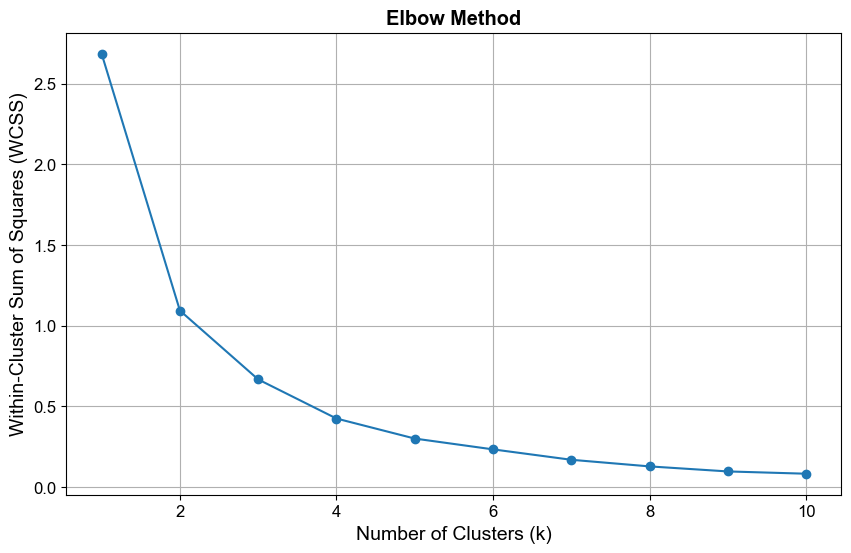

In [185]:
# section likes to crash

# Taking a smaller random subset of the data for faster computation (% of the data)
smaller_subset_data = df_yield_value_year_standardized[cluster_columns].sample(frac=0.01, random_state=42)

# Perform the Elbow Method to find the optimal number of clusters (consider up to 10 clusters)
elbow_method(smaller_subset_data, max_clusters=10)

## Perform k-Means Clustering k=4

In [186]:
# Perform k-means clustering with k=4, focusing only on the 'Value' column
clustered_data_single = perform_kmeans(df_yield_value_year_standardized_single[['Value']], n_clusters=4)

# Display the first few rows of the data with cluster labels
clustered_data_single.head()

,Value,Cluster
2877,-0.784362,0
3642,-0.808798,0
7892,-0.849572,0
7977,-0.898585,0
8062,-0.237755,2


## Analyze the Resulting K-Means Clusters

In [187]:
# Compute summary statistics for each cluster, focusing only on the 'Value' column
summary_stats_single = cluster_summary_statistics(clustered_data_single, 'Cluster', ['Value'])
# Flatten the DataFrame by resetting the index
summary_stats_single = summary_stats_single.reset_index()

# Flatten the multi-level column index
summary_stats_single.columns = ['_'.join(col).strip() for col in summary_stats_single.columns.values]
summary_stats_single.rename(columns={'Cluster_': 'Cluster'}, inplace=True)
summary_stats_single

,Cluster,Value_mean,Value_median,Value_std
0,0,-1.102101,-1.000625,0.390807
1,1,0.685314,0.598634,0.352736
2,2,-0.168007,-0.149166,0.257825
3,3,2.899554,2.861540,0.689749


In [188]:
# Review results
print("k-Means Results: " + format_summary_stats(summary_stats_single))

k-Means Results: The summary statistics for each of the four clusters based on the Value feature are as follows:

Cluster 0.0:
Value: Mean = -1.10, Median = -1.00, Std = 0.39
Cluster 1.0:
Value: Mean = 0.69, Median = 0.60, Std = 0.35
Cluster 2.0:
Value: Mean = -0.17, Median = -0.15, Std = 0.26
Cluster 3.0:
Value: Mean = 2.90, Median = 2.86, Std = 0.69



## Visualize k-Means Clusters

In [189]:
clustered_data_single

,Value,Cluster
2877,-0.784362,0
3642,-0.808798,0
7892,-0.849572,0
7977,-0.898585,0
8062,-0.237755,2
...,...,...
2687,1.562908,1
2716,2.330355,3
2744,2.628376,3
2774,1.905083,3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


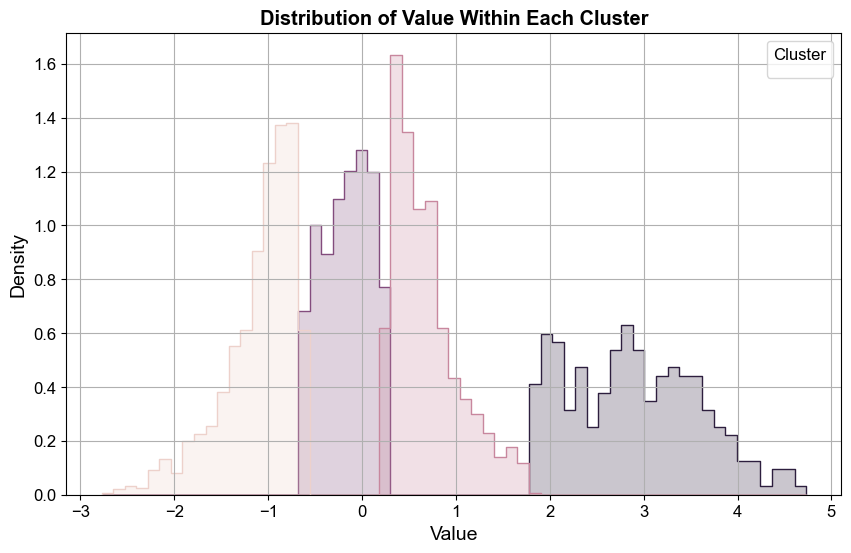

In [190]:
visualize_single_feature_clusters(clustered_data_single, 'Value', 'Cluster')


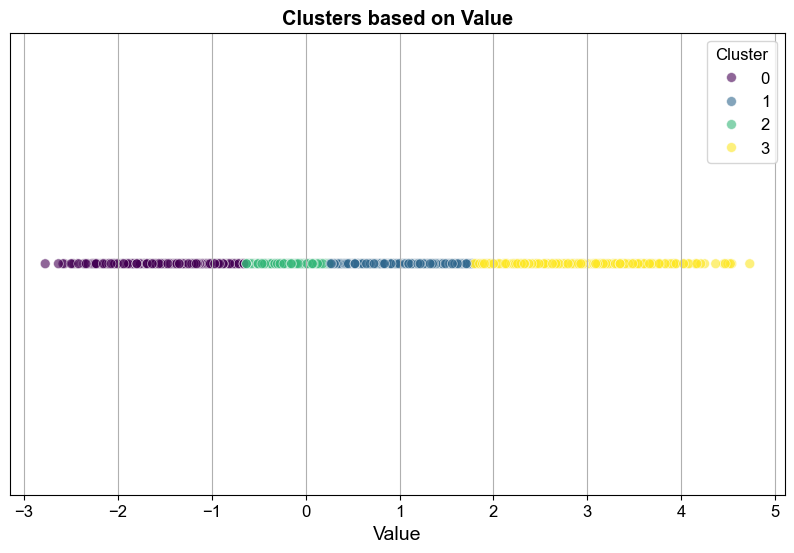

In [191]:
# Visualize as scatter plot
visualize_single_feature_scatter(clustered_data_single, 'Value')

In [192]:
# change the visualizations to see the original value figures vs scaled valus 

# Map the cluster labels back to the original DataFrame
df_yield_value_year['Cluster'] = clustered_data_single['Cluster']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


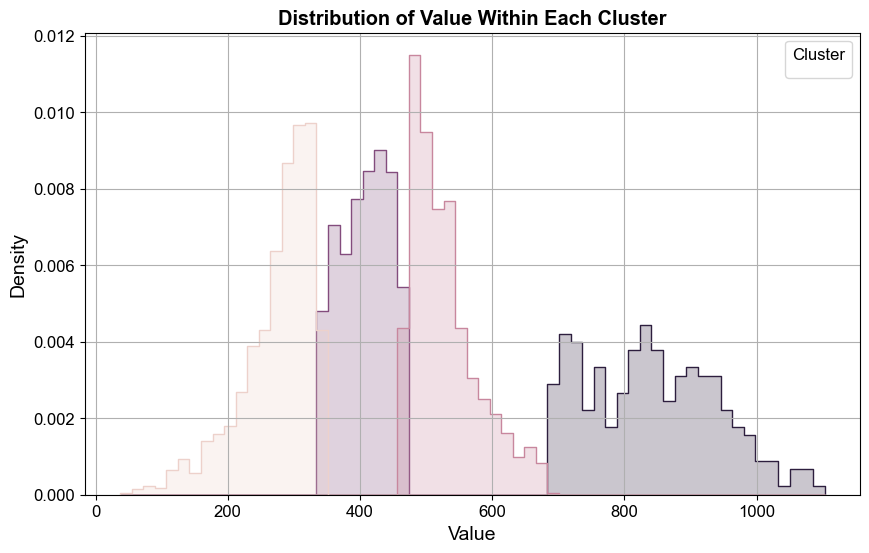

In [193]:
visualize_single_feature_clusters(df_yield_value_year, 'Value', 'Cluster')

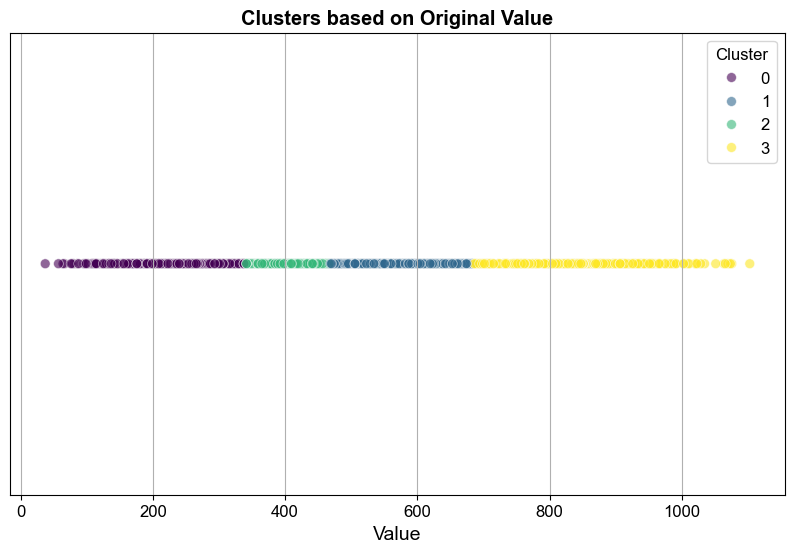

In [194]:
visualize_single_feature_scatter_original(df_yield_value_year, 'Value')

### Violin Plot for Clusters

/var/folders/my/0mhfb48n2w7c86qd4qdk2bsw0000gn/T/ipykernel_35332/1533545740.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




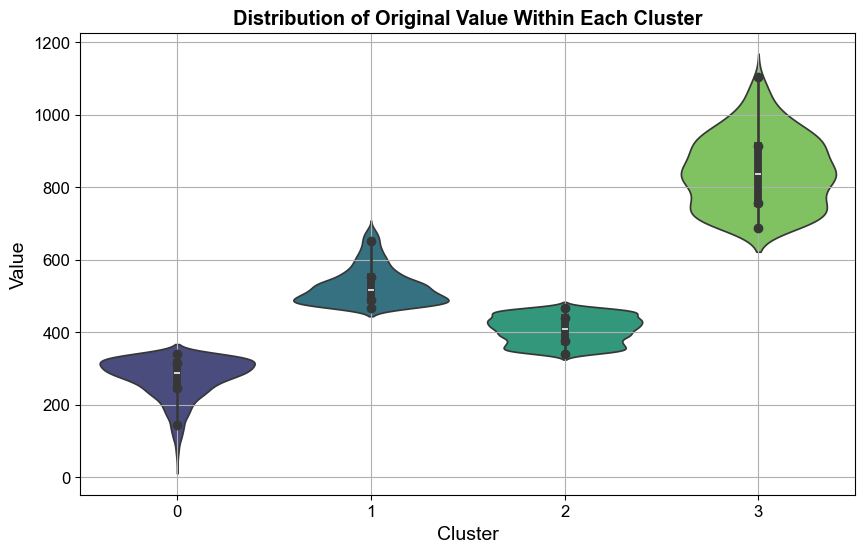

In [195]:
visualize_clusters_violin(df_yield_value_year, 'Value', 'Cluster')

## Verify with Silhouette Analysis

In [196]:
# this just creates noise
# silhouette_analysis(df_yield_value_year_standardized_single[['Value']], max_clusters=5)


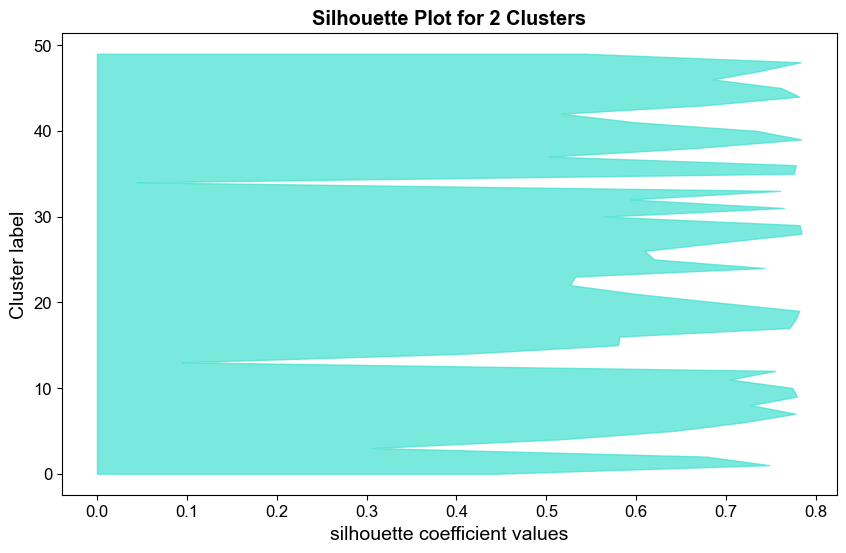

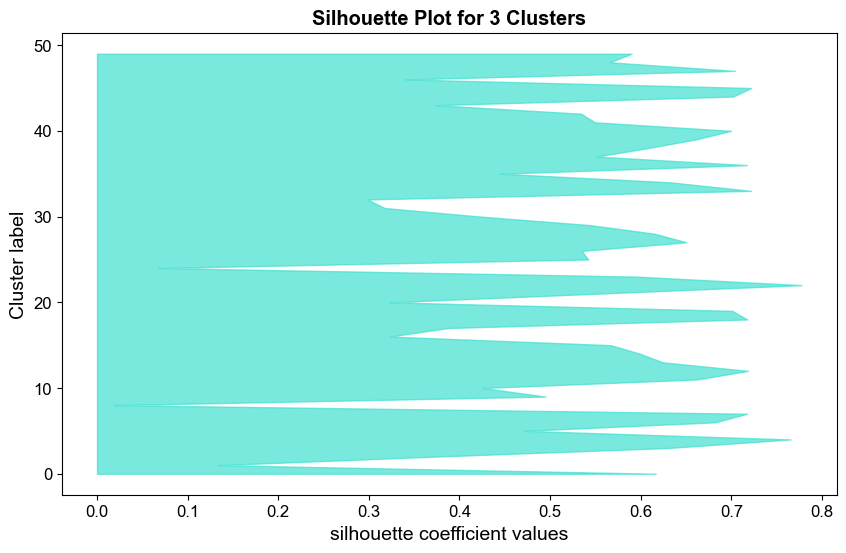

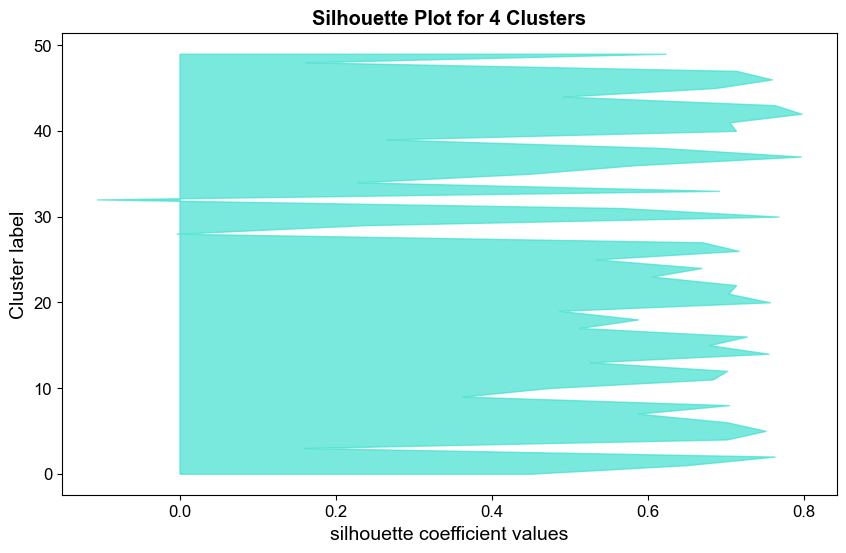

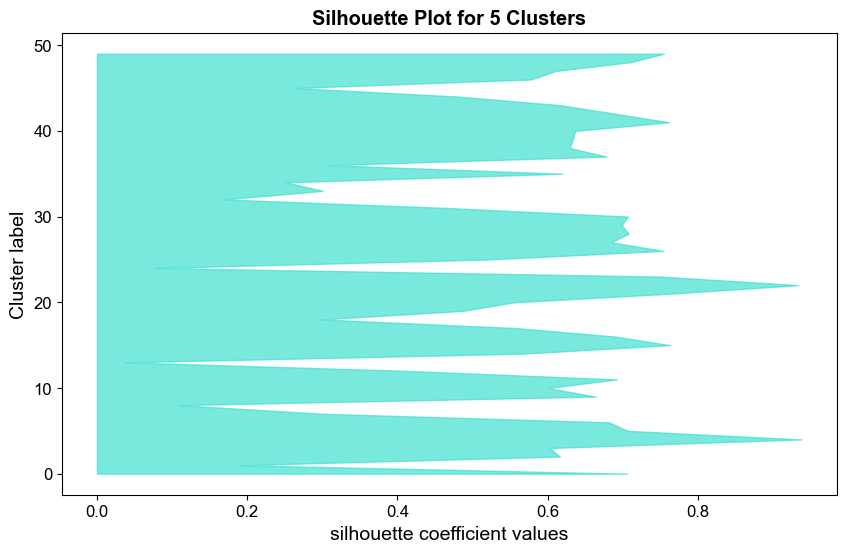


Silhouette Scores for Different Numbers of Clusters:
   Number of Clusters  Silhouette Score Percentage
0                   2                     0.643796
1                   3                     0.539666
2                   4                     0.576755
3                   5                     0.558404


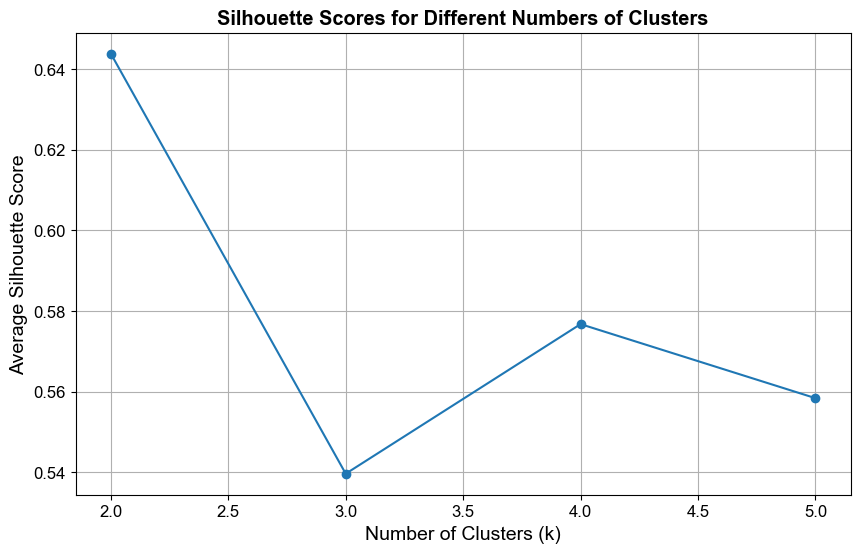

In [197]:
# Taking a smaller random subset of the data for faster computation (1% of the data)
smaller_subset_data_single = df_yield_value_year_standardized_single[['Value']].sample(frac=0.01, random_state=42)

# Perform silhouette analysis for k=2 to k=5 (as k=1 is not valid for silhouette analysis) on the smaller subset
silhouette_analysis(smaller_subset_data_single, max_clusters=5)


## Perform k-Means Clustering k=2

In [198]:
# Perform k-means clustering with k=2, focusing only on the 'Value' column
clustered_data_two = perform_kmeans(df_yield_value_year_standardized_single[['Value']], n_clusters=2)

# Map the cluster labels back to the original DataFrame
df_yield_value_year['Cluster_k2'] = clustered_data_two['Cluster']

cluster_summary_statistics(df_yield_value_year, 'Cluster_k2', ['Value'])

Value                    
                  mean  median         std
Cluster_k2                                
0           363.192356  375.65   79.342867
1           587.211860  534.16  130.702346

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


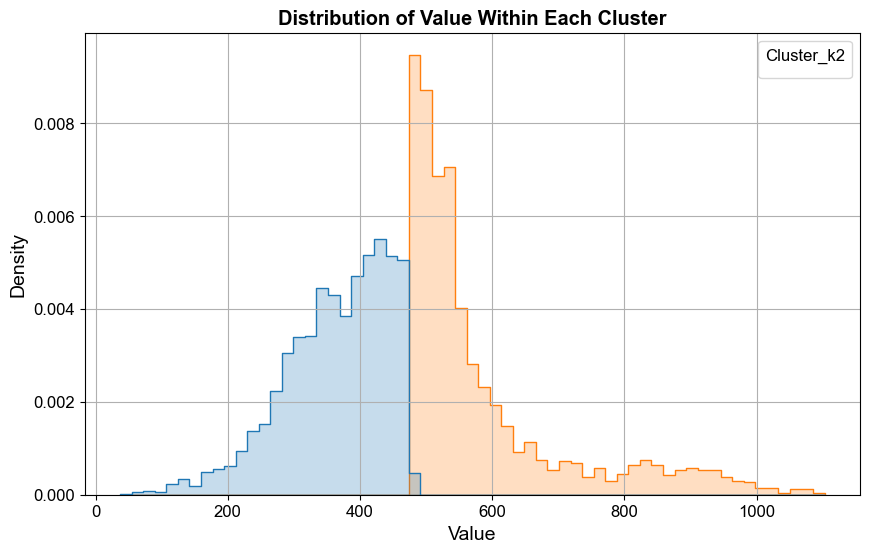

In [199]:
visualize_single_feature_clusters(df_yield_value_year, 'Value', 'Cluster_k2')

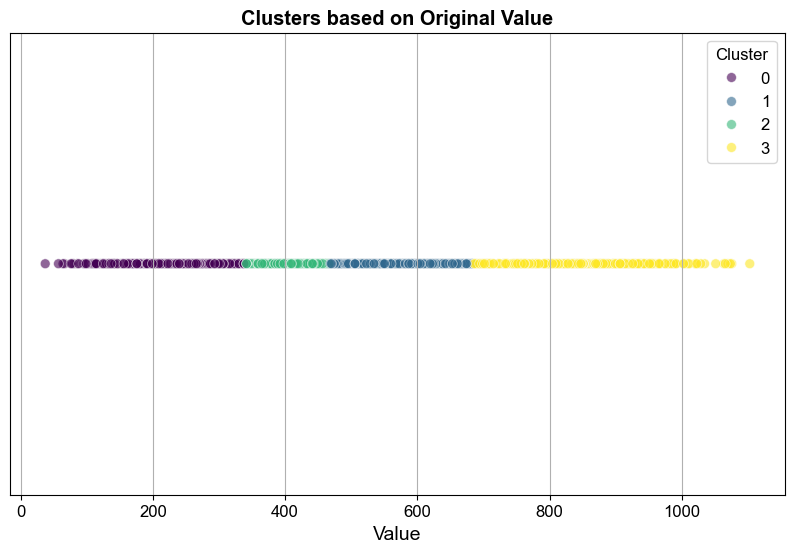

In [200]:
# Visualize the clusters based on original 'Value' using a scatter plot
visualize_single_feature_scatter_original(df_yield_value_year, 'Value')

/var/folders/my/0mhfb48n2w7c86qd4qdk2bsw0000gn/T/ipykernel_35332/1533545740.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




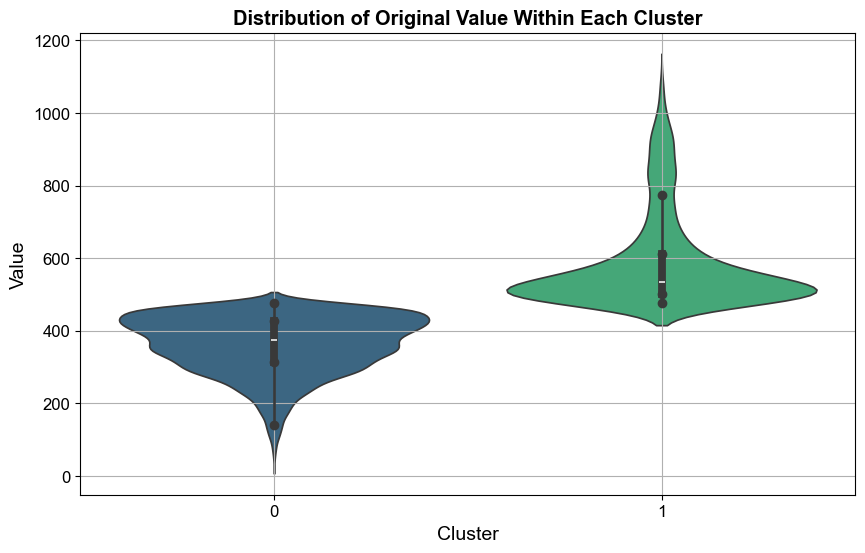

In [201]:
# Create a violin plot for the clusters using original 'Value'
visualize_clusters_violin(df_yield_value_year, 'Value', 'Cluster_k2')

## k-Means 2 vs 4 Comparison

In [202]:
df_yield_value_year_standardized_single

,RM,Year,Canola,Value
2877,1,2010,27.600,-0.784362
3642,10,2010,27.300,-0.808798
7892,100,2010,26.800,-0.849572
7977,101,2010,26.200,-0.898585
8062,102,2010,34.300,-0.237755
...,...,...,...,...
2687,WHITEHEAD,2022,33.453,1.562908
2716,WHITEMOUTH,2022,39.036,2.330355
2744,WINNIPEG,2022,41.204,2.628376
2774,WOODLANDS,2022,35.942,1.905083


In [203]:
# Calculate silhouette scores for k=2 and k=4 based on the 'Value' column
silhouette_score_k2 = silhouette_score(df_yield_value_year_standardized_single[['Value']], df_yield_value_year['Cluster_k2'])
silhouette_score_k4 = silhouette_score(df_yield_value_year_standardized_single[['Value']], df_yield_value_year['Cluster'])

silhouette_score_k2.round(3)*100, silhouette_score_k4.round(3)*100

(52.2, 52.0)

In [204]:
# Calculate silhouette scores for k=2 and k=4 based on the 'Value' column
silhouette_score_k2 = silhouette_score(df_yield_value_year_standardized_single[['Value']], df_yield_value_year['Cluster_k2'])
silhouette_score_k4 = silhouette_score(df_yield_value_year_standardized_single[['Value']], clustered_data_single['Cluster'])

silhouette_score_k2.round(3)*100, silhouette_score_k4.round(3)*100

(52.2, 52.0)

In [205]:
# Compute silhouette scores manually for k=2
silhouette_scores_manual_k2 = silhouette_samples(df_yield_value_year_standardized_single[['Value']], df_yield_value_year['Cluster_k2'])

# Compute silhouette scores manually for k=4
silhouette_scores_manual_k4 = silhouette_samples(df_yield_value_year_standardized_single[['Value']], clustered_data_single['Cluster'])

# Calculate the average silhouette score for each case
average_silhouette_score_manual_k2 = silhouette_scores_manual_k2.mean()
average_silhouette_score_manual_k4 = silhouette_scores_manual_k4.mean()

# Print the results
print("Average Silhouette Score (k=2) Manual:", average_silhouette_score_manual_k2)
print("Average Silhouette Score (k=4) Manual:", average_silhouette_score_manual_k4)


Average Silhouette Score (k=2) Manual: 0.5217013495584752
Average Silhouette Score (k=4) Manual: 0.5204044475438391


In [206]:
# try another method for the silhouette scores
# Reshape your data to a 2D array
data_2d = df_yield_value_year_standardized_single[['Value']].values.reshape(-1, 1)

# Calculate silhouette score for k=2
silhouette_score_k2 = calculate_silhouette_scores(data_2d, df_yield_value_year['Cluster_k2'])

# Calculate silhouette score for k=4
cluster_labels_k4 = clustered_data_single['Cluster']
silhouette_score_k4 = calculate_silhouette_scores(data_2d, cluster_labels_k4)

# Print the silhouette scores
print(f"Silhouette Score for k=2: {silhouette_score_k2:.3f}")
print(f"Silhouette Score for k=4: {silhouette_score_k4:.3f}")


Silhouette Score for k=2: 0.522
Silhouette Score for k=4: 0.520


In [207]:
# Errors out
# # Taking a smaller random subset of the data for silhouette score calculation (10% of the data)
# smaller_subset_data_k2 = df_yield_value_year[['Value', 'Cluster_k2']].sample(frac=0.1, random_state=42)
# smaller_subset_data_k4 = clustered_data_single[['Value', 'Cluster']].sample(frac=0.1, random_state=42)

# # Standardize the 'Value' column for the smaller subsets
# smaller_subset_data_k2_standardized = scaler.transform(smaller_subset_data_k2[['Value']])
# smaller_subset_data_k4_standardized = scaler.transform(smaller_subset_data_k4[['Value']])

# # Calculate silhouette scores for k=2 and k=4 based on the 'Value' column for the smaller subsets
# silhouette_score_k2_subset = silhouette_score(smaller_subset_data_k2_standardized, smaller_subset_data_k2['Cluster_k2'])
# silhouette_score_k4_subset = silhouette_score(smaller_subset_data_k4_standardized, smaller_subset_data_k4['Cluster'])

# silhouette_score_k2_subset, silhouette_score_k4_subset


In [208]:
# Drop the previous cluster column and rename the new one for k=2 clustering
df_yield_value_year_clean_k2 = df_yield_value_year.drop('Cluster', axis=1).rename(columns={'Cluster_k2': 'Cluster'})

# Drop the previous cluster column and rename the new one for k=4 clustering
clustered_data_k4 = clustered_data_single.rename(columns={'Cluster': 'Cluster'})

# Compute additional statistics for k=2 clusters
additional_stats_k2 = additional_cluster_statistics(df_yield_value_year_clean_k2, 'Cluster', 'Value')

# Compute additional statistics for k=4 clusters
additional_stats_k4 = additional_cluster_statistics(clustered_data_k4, 'Cluster', 'Value')

additional_stats_k2, additional_stats_k4

(   Cluster  count     min      max        mean  median         std      skew  \
 0        0   3472   37.09   475.56  363.192356  375.65   79.342867 -0.804785   
 1        1   1511  475.85  1102.97  587.211860  534.16  130.702346  1.713088   
 
    kurtosis  
 0  0.352295  
 1  2.100470  ,
    Cluster  count       min       max      mean    median       std      skew  \
 0        0   1219 -2.774809 -0.637957 -1.102101 -1.000625  0.390807 -1.275240   
 1        1   1388  0.257726  1.786917  0.685314  0.598634  0.352736  1.078801   
 2        2   2118 -0.636971  0.257093 -0.168007 -0.149166  0.257825 -0.137471   
 3        3    258  1.797973  4.731215  2.899554  2.861540  0.689749  0.289825   
 
    kurtosis  
 0  1.435909  
 1  0.544665  
 2 -1.158503  
 3 -0.688944  )

In [209]:
# improve formatting of additional stats, as dataframes

# Define column headers
headers = ['Cluster', 'count', 'min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis']

# Create a dictionary to store the DataFrames
dataframes = {
    'additional_stats_k2': additional_stats_k2,
    'additional_stats_k4': additional_stats_k4
}

# Create a dictionary to store the summary statistics DataFrames
summary_stats_dataframes = {}

# Loop through the DataFrames and store them in the summary_stats_dataframes dictionary
for df_name, df in dataframes.items():
    summary_stats_df = pd.DataFrame(columns=headers)
    
    # Iterate through the DataFrames and add rows to the summary_stats_df
    for _, row in df.iterrows():
        summary_stats_df = pd.concat([summary_stats_df, pd.DataFrame([row], columns=headers)], ignore_index=True)
    
    summary_stats_dataframes[df_name] = summary_stats_df

# Now you have the summary statistics as DataFrames in the summary_stats_dataframes dictionary
# You can access them like this:
# print("Summary Statistics for additional_stats_k2:")
# print(summary_stats_dataframes['additional_stats_k2'])

# print("\nSummary Statistics for additional_stats_k4:")
# print(summary_stats_dataframes['additional_stats_k4'])


/var/folders/my/0mhfb48n2w7c86qd4qdk2bsw0000gn/T/ipykernel_35332/2001987117.py:21: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/var/folders/my/0mhfb48n2w7c86qd4qdk2bsw0000gn/T/ipykernel_35332/2001987117.py:21: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [210]:
print("Summary Statistics for additional_stats_k2:")
summary_stats_dataframes['additional_stats_k2']

Summary Statistics for additional_stats_k2:


,Cluster,count,min,max,mean,median,std,skew,kurtosis
0,0.0,3472.0,37.09,475.56,363.192356,375.65,79.342867,-0.804785,0.352295
1,1.0,1511.0,475.85,1102.97,587.211860,534.16,130.702346,1.713088,2.100470


In [211]:
print("Summary Statistics for additional_stats_k4:")
summary_stats_dataframes['additional_stats_k4']

Summary Statistics for additional_stats_k4:


,Cluster,count,min,max,mean,median,std,skew,kurtosis
0,0.0,1219.0,-2.774809,-0.637957,-1.102101,-1.000625,0.390807,-1.275240,1.435909
1,1.0,1388.0,0.257726,1.786917,0.685314,0.598634,0.352736,1.078801,0.544665
2,2.0,2118.0,-0.636971,0.257093,-0.168007,-0.149166,0.257825,-0.137471,-1.158503
3,3.0,258.0,1.797973,4.731215,2.899554,2.861540,0.689749,0.289825,-0.688944


In [212]:
# Create a dictionary to store the data
comparison_data = {
    'Metrics': ['Count', 'Min Value', 'Max Value', 'Mean Value', 'Median Value', 'Std Dev Value', 'Skewness', 'Kurtosis', 'Silhouette Score'],
    'k2 (0)': [additional_stats_k2.loc[0, 'count'], additional_stats_k2.loc[0, 'min'], additional_stats_k2.loc[0, 'max'], additional_stats_k2.loc[0, 'mean'], additional_stats_k2.loc[0, 'median'], additional_stats_k2.loc[0, 'std'], additional_stats_k2.loc[0, 'skew'], additional_stats_k2.loc[0, 'kurtosis'], silhouette_score_k2.round(3)],
    'k2 (1)': [additional_stats_k2.loc[1, 'count'], additional_stats_k2.loc[1, 'min'], additional_stats_k2.loc[1, 'max'], additional_stats_k2.loc[1, 'mean'], additional_stats_k2.loc[1, 'median'], additional_stats_k2.loc[1, 'std'], additional_stats_k2.loc[1, 'skew'], additional_stats_k2.loc[1, 'kurtosis'], ''],
    'k4 (0)': [additional_stats_k4.loc[0, 'count'], additional_stats_k4.loc[0, 'min'], additional_stats_k4.loc[0, 'max'], additional_stats_k4.loc[0, 'mean'], additional_stats_k4.loc[0, 'median'], additional_stats_k4.loc[0, 'std'], additional_stats_k4.loc[0, 'skew'], additional_stats_k4.loc[0, 'kurtosis'], ''],
    'k4 (1)': [additional_stats_k4.loc[1, 'count'], additional_stats_k4.loc[1, 'min'], additional_stats_k4.loc[1, 'max'], additional_stats_k4.loc[1, 'mean'], additional_stats_k4.loc[1, 'median'], additional_stats_k4.loc[1, 'std'], additional_stats_k4.loc[1, 'skew'], additional_stats_k4.loc[1, 'kurtosis'], ''],
    'k4 (2)': [additional_stats_k4.loc[2, 'count'], additional_stats_k4.loc[2, 'min'], additional_stats_k4.loc[2, 'max'], additional_stats_k4.loc[2, 'mean'], additional_stats_k4.loc[2, 'median'], additional_stats_k4.loc[2, 'std'], additional_stats_k4.loc[2, 'skew'], additional_stats_k4.loc[2, 'kurtosis'], ''],
    'k4 (3)': [additional_stats_k4.loc[3, 'count'], additional_stats_k4.loc[3, 'min'], additional_stats_k4.loc[3, 'max'], additional_stats_k4.loc[3, 'mean'], additional_stats_k4.loc[3, 'median'], additional_stats_k4.loc[3, 'std'], additional_stats_k4.loc[3, 'skew'], additional_stats_k4.loc[3, 'kurtosis'], silhouette_score_k4.round(3)]
}

# Create the comparison table DataFrame
comparison_table = pd.DataFrame(comparison_data)

# Set 'Metrics' column as the index
comparison_table.set_index('Metrics', inplace=True)

# Round the values to 2 decimal places
comparison_table = comparison_table.round(2)

# Print the comparison table
print("Comparison Table:")
comparison_table


Comparison Table:


,k2 (0),k2 (1),k4 (0),k4 (1),k4 (2),k4 (3)
Metrics,,,,,,
Count,3472.00,1511,1219,1388,2118,258.00
Min Value,37.09,475.85,-2.774809,0.257726,-0.636971,1.80
Max Value,475.56,1102.97,-0.637957,1.786917,0.257093,4.73
Mean Value,363.19,587.21186,-1.102101,0.685314,-0.168007,2.90
Median Value,375.65,534.16,-1.000625,0.598634,-0.149166,2.86
Std Dev Value,79.34,130.702346,0.390807,0.352736,0.257825,0.69
Skewness,-0.80,1.713088,-1.27524,1.078801,-0.137471,0.29
Kurtosis,0.35,2.10047,1.435909,0.544665,-1.158503,-0.69
Silhouette Score,0.52,,,,,0.52


In this analysis, we explored k-means clustering with k=2 and k=4 to segment data based on the Value feature. For k=2, Cluster 0 primarily encompasses lower values with a mean of 363.19, while Cluster 1 has a higher mean value of 587.21. The silhouette score for this clustering is 0.592, suggesting relatively well-defined clusters. For k=4, the clusters are more nuanced but have a slightly lower silhouette score of 0.552. Additional metrics such as skewness and kurtosis offer insights into the shape of the data distribution within each cluster. Overall, both k=2 and k=4 offer valuable but different perspectives on the data segmentation. The choice between them may depend on the specific needs of further analysis or domain-specific interpretation.

# Clustering Methods: DBSCAN

In [213]:
# preprocessing skipped
# Assuming df_yield_value_year is the cleaned DataFrame
# No need to standardize the 'Value' column for DBSCAN

In [214]:
# parameter tuning - create a grid of parameters
# parameter tuning - create a grid of parameters
epsilon_values = [0.2, 1, 5, 10, 20]
min_pts_values = [5, 10, 20, 40, 60]
dbscan_results = []

for eps in epsilon_values:
    for min_pts in min_pts_values:
        clustered_data_temp = perform_dbscan(df_yield_value_year[['Value']], eps, min_pts)
        num_clusters = len(clustered_data_temp['Cluster'].unique()) - 1
        num_noise_points = len(clustered_data_temp[clustered_data_temp['Cluster'] == -1])
        dbscan_results.append({'Epsilon': eps, 'MinPts': min_pts, 'Num_Clusters': num_clusters, 'Num_Noise_Points': num_noise_points})

# Convert the list of dictionaries to a DataFrame
dbscan_results_df = pd.DataFrame(dbscan_results)

In [215]:
dbscan_results_df

,Epsilon,MinPts,Num_Clusters,Num_Noise_Points
0,0.2,5,281,1287
1,0.2,10,136,3076
2,0.2,20,1,4961
3,0.2,40,0,4983
4,0.2,60,0,4983
5,1.0,5,38,357
6,1.0,10,17,696
7,1.0,20,12,1176
8,1.0,40,22,3465
9,1.0,60,0,4983


In [216]:
# automatically select optimal parameters
# Criteria for 'optimal' can be modified as needed
optimal_params = dbscan_results_df.loc[dbscan_results_df['Num_Clusters'] == 2].sort_values(by='Num_Noise_Points').iloc[0]
epsilon_optimal = optimal_params['Epsilon']
min_points_optimal = optimal_params['MinPts']

In [217]:
# perform DBSCAN clustering with optimal parameters

# Convert epsilon_optimal and min_points_optimal to integers
epsilon_optimal = int(epsilon_optimal)
min_points_optimal = int(min_points_optimal)

# Perform DBSCAN clustering with optimal parameters
clustered_data_dbscan_optimal = perform_dbscan(df_yield_value_year[['Value']], epsilon_optimal, min_points_optimal)

# Add the DBSCAN cluster labels to your DataFrame
df_yield_value_year['DBSCAN_Cluster_Optimal'] = clustered_data_dbscan_optimal['Cluster']


In [254]:
# compute and display summary statistics
summary_stats_dbscan_optimal = cluster_summary_statistics(df_yield_value_year, 'DBSCAN_Cluster_Optimal', ['Value'])
summary_stats_dbscan_optimal

Value                      
                              mean    median         std
DBSCAN_Cluster_Optimal                                  
-1                      691.616000  1011.210  476.354946
 0                      428.686584   421.265  135.062594
 1                      984.936000   987.790    5.976233

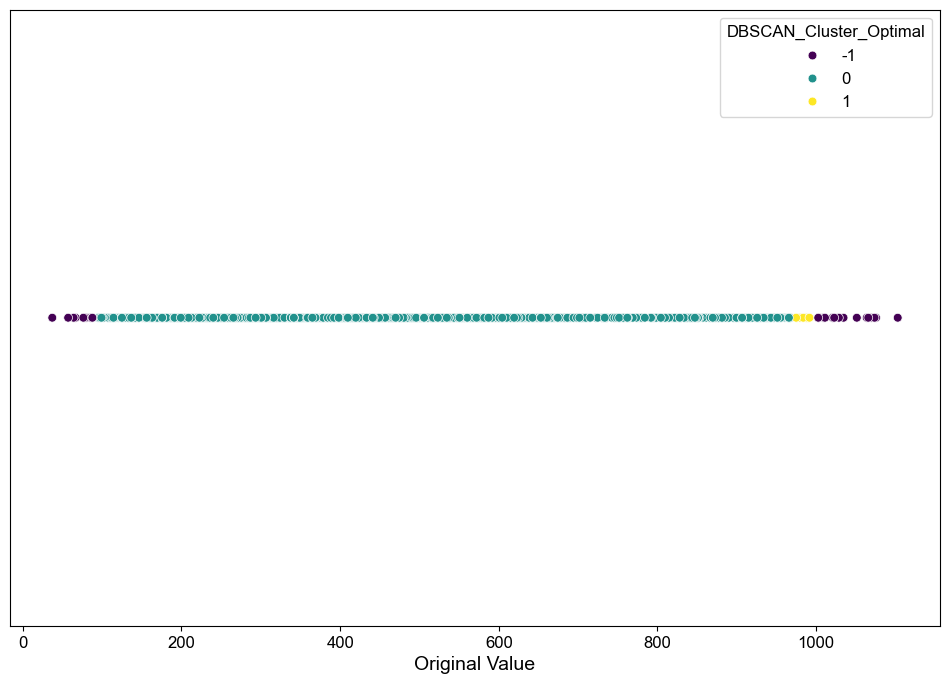

In [220]:
# visualize the clusters
sns.scatterplot(x='Value', y=np.zeros(len(df_yield_value_year)), hue='DBSCAN_Cluster_Optimal', palette='viridis', data=df_yield_value_year, s=40)
plt.xlabel('Original Value')
plt.yticks([])
plt.show()

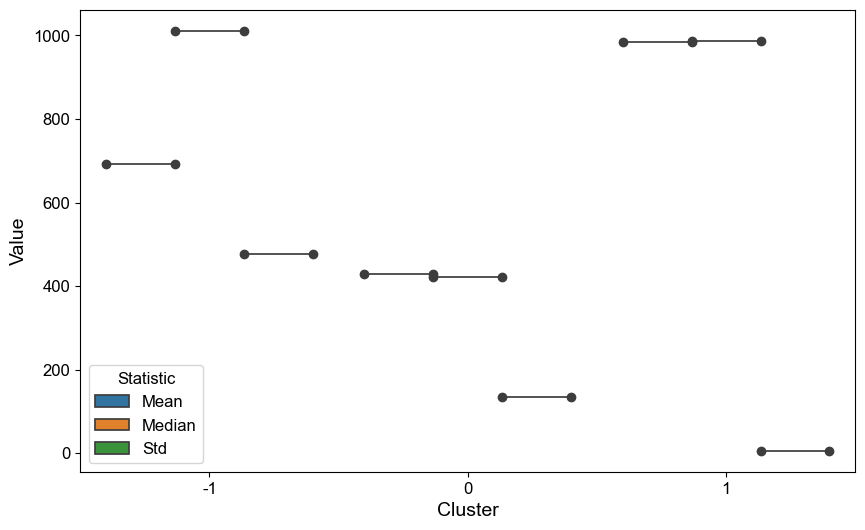

In [255]:
# Flatten the column headers
summary_stats_dbscan_optimal.columns = ['_'.join(col).strip() for col in summary_stats_dbscan_optimal.columns.values]

# Reset the index to flatten the DataFrame
summary_stats_dbscan_optimal = summary_stats_dbscan_optimal.reset_index()

# Rename the columns to make them more suitable for melting
summary_stats_dbscan_optimal.rename(columns={
    'DBSCAN_Cluster_Optimal': 'Cluster',
    'Value_mean': 'Mean',
    'Value_median': 'Median',
    'Value_std': 'Std'
}, inplace=True)

# Reshape the DataFrame using melt
summary_stats_long = pd.melt(summary_stats_dbscan_optimal, id_vars='Cluster', var_name='Statistic', value_name='Value')

# Create a violin plot
plt.figure(figsize=(10, 6))

sns.violinplot(x='Cluster', y='Value', hue='Statistic', data=summary_stats_long, split=True)

plt.show()


In [252]:
# # # Flatten the column headers
# summary_stats_dbscan_optimal.columns = ['_'.join(col).strip() for col in summary_stats_dbscan_optimal.columns.values]

# # Reset the index to flatten the DataFrame
# summary_stats_dbscan_optimal = summary_stats_dbscan_optimal.reset_index()

# # Rename the columns to make them more suitable for melting
# # summary_stats_dbscan_optimal.rename(columns={
# #     'DBSCAN_Cluster_Optimal': 'Cluster',
# #     'Value_mean': 'Mean',
# #     'Value_median': 'Median',
# #     'Value_std': 'Std'
# # }, inplace=True)
# summary_stats_dbscan_optimal

,DBSCAN_Cluster_Optimal,Value_mean,Value_median,Value_std
0,-1,691.616000,1011.210,476.354946
1,0,428.686584,421.265,135.062594
2,1,984.936000,987.790,5.976233


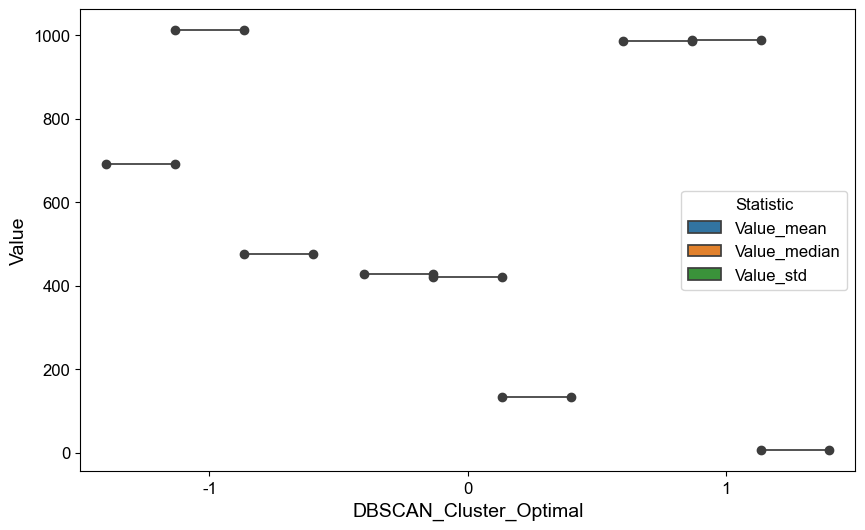

In [253]:
# # Reshape the DataFrame using melt
# summary_stats_long = pd.melt(summary_stats_dbscan_optimal, id_vars='DBSCAN_Cluster_Optimal', var_name='Statistic', value_name='Value')

# # Create a violin plot
# plt.figure(figsize=(10, 6))

# sns.violinplot(x='DBSCAN_Cluster_Optimal', y='Value', hue='Statistic', data=summary_stats_long, split=True)

# plt.show()

In [257]:
# summary_stats_long = summary_stats_dbscan_optimal.reset_index().melt(id_vars='DBSCAN_Cluster_Optimal', var_name='Statistic', value_name='Value')


In [258]:
summary_stats_long

,Cluster,Statistic,Value
0,-1,Mean,691.616000
1,0,Mean,428.686584
2,1,Mean,984.936000
3,-1,Median,1011.210000
4,0,Median,421.265000
5,1,Median,987.790000
6,-1,Std,476.354946
7,0,Std,135.062594
8,1,Std,5.976233


In [260]:
# # Now, create a violin plot
# plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# sns.violinplot(x='DBSCAN_Cluster_Optimal', y='Value', hue='Statistic', data=summary_stats_long, split=True)

# plt.show()

In [263]:
# plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# sns.violinplot(x='DBSCAN_Cluster_Optimal', y='Value', hue='Statistic', data=summary_stats_dbscan_optimal, split=True)

# plt.show()


### DBSCAN Conclusion

The results from the violin plot and the summary statistics for DBSCAN clustering with optimal settings show three distinct clusters: -1, 0, and 1.

Cluster -1: This cluster appears to represent outliers or noise in the data, as indicated by its label of -1, which is typical in DBSCAN clustering. The mean value for this cluster is approximately 691.62, with a median value of 1011.21. The standard deviation is high, at around 476.35, suggesting a wide dispersion of values around the mean, which is typical for a cluster containing outliers or noise.

Cluster 0: This cluster has a mean value of approximately 428.69 and a median value of 421.27, which are relatively close to each other. The standard deviation is 135.06, indicating a moderate level of variability within this cluster. This cluster seems to represent the "average" or "typical" data points in the dataset.

Cluster 1: This cluster has a mean value of approximately 984.94 and a median value of 987.79. Notably, the standard deviation is extremely low, at just 5.98, indicating that the values in this cluster are highly concentrated around the mean. This suggests that the data points in this cluster are very similar to each other.

## Analyze DBSCAN with Silouette

In [264]:
df_yield_value_year

,RM,Year,Canola,Value,Cluster,Cluster_k2,DBSCAN_Cluster_Optimal
2877,1,2010,27.600,319.74,0,0,0
3642,10,2010,27.300,316.27,0,0,0
7892,100,2010,26.800,310.48,0,0,0
7977,101,2010,26.200,303.52,0,0,0
8062,102,2010,34.300,397.36,2,0,0
...,...,...,...,...,...,...,...
2687,WHITEHEAD,2022,33.453,653.06,1,1,0
2716,WHITEMOUTH,2022,39.036,762.04,3,1,0
2744,WINNIPEG,2022,41.204,804.36,3,1,0
2774,WOODLANDS,2022,35.942,701.65,3,1,0


In [265]:
# Assuming you have a DataFrame 'df_yield_value_year' with columns: RM, Year, Canola, Value, DBSCAN_Cluster_Optimal

# Encode the categorical feature "RM" in df_yield_value_year
encoder = OneHotEncoder(sparse=False)
encoded_RM = encoder.fit_transform(df_yield_value_year[['RM']])

# Combine the encoded feature with your numerical data
X_encoded = np.hstack((df_yield_value_year.drop(['RM'], axis=1).values, encoded_RM))

# Use the 'DBSCAN_Cluster_Optimal' column as cluster labels
cluster_labels = df_yield_value_year['DBSCAN_Cluster_Optimal'].values

# Calculate the silhouette score using the cluster labels
silhouette_avg = silhouette_score(X_encoded, cluster_labels)

# ignore warnings, calculation still succeeds

/Users/clintonboyda/anaconda3/envs/geo_env/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [266]:
print("DBSCAN Results:\n" + silhouette_results_interpretation(silhouette_avg))

DBSCAN Results:
Silhouette Score: 0.6721 (Strongly Separated Clusters)
This indicates that the clusters are well-separated.


# Final Datasets

In [268]:
df_data_merged
# maximum dataset RM Year YIELD data with Value added

,RM,Year,Canola,Value
0,ALEXANDER,1993,11.067,NaN
1,ALEXANDER,1994,12.743,NaN
2,ALEXANDER,1995,27.337,NaN
3,ALEXANDER,1996,33.304,NaN
4,ALEXANDER,1997,28.719,NaN
...,...,...,...,...
28112,622,2018,39.300,448.77
28113,622,2019,46.100,477.36
28114,622,2020,40.900,461.19
28115,622,2021,23.900,455.56


In [276]:
df_price_merged
# all the df_data_merged since 2010 but containing nulls

,RM,Year,Canola,Price,Value
0,ALEXANDER,2010,14.440130,11.584916,167.287689
1,ALONSA,2010,17.989536,11.584916,208.407259
2,ARGYLE,2010,42.970803,11.584916,497.813137
3,ARMSTRONG,2010,11.419828,11.584916,132.297745
4,BIFROST-RIVERTON,2010,9.523872,11.584916,110.333255
...,...,...,...,...,...
5055,520,2022,47.900000,19.521513,935.080458
5056,555,2022,39.900000,19.521513,778.908356
5057,561,2022,28.200000,19.521513,550.506658
5058,588,2022,35.900000,19.521513,700.822305


In [278]:
df_price_merged.isnull().sum()
# nulls, 5060-77 = 4983 in df_yield_value_year

RM         0
Year       0
Canola    77
Price      0
Value     77
dtype: int64

In [267]:
df_yield_value_year
# Canola Yield and Stock Price data without any nulls, starts at 2010

,RM,Year,Canola,Value,Cluster,Cluster_k2,DBSCAN_Cluster_Optimal
2877,1,2010,27.600,319.74,0,0,0
3642,10,2010,27.300,316.27,0,0,0
7892,100,2010,26.800,310.48,0,0,0
7977,101,2010,26.200,303.52,0,0,0
8062,102,2010,34.300,397.36,2,0,0
...,...,...,...,...,...,...,...
2687,WHITEHEAD,2022,33.453,653.06,1,1,0
2716,WHITEMOUTH,2022,39.036,762.04,3,1,0
2744,WINNIPEG,2022,41.204,804.36,3,1,0
2774,WOODLANDS,2022,35.942,701.65,3,1,0


In [269]:
df_yield_value_year_standardized

,RM,Year,Canola,Value
2877,1,2010,0.448047,0.265180
3642,10,2010,0.442817,0.261924
7892,100,2010,0.434100,0.256492
7977,101,2010,0.423640,0.249962
8062,102,2010,0.564854,0.338002
...,...,...,...,...
2687,WHITEHEAD,2022,0.550087,0.577898
2716,WHITEMOUTH,2022,0.647420,0.680142
2744,WINNIPEG,2022,0.685216,0.719847
2774,WOODLANDS,2022,0.593480,0.623485


In [270]:
df_data_agg
# based on df_yield_value_year but AGGREGATED for each RM over all years

,RM,Canola_mean,Canola_std,Value_mean,Value_std,Canola_scaled,Value_scaled
0,1,31.342,6.882,401.699,145.267,0.521702,0.458187
1,10,26.241,7.441,333.429,118.325,0.338877,0.296039
2,100,34.815,7.561,445.460,161.423,0.646178,0.562125
3,101,28.982,5.627,368.375,114.470,0.437117,0.379039
4,102,35.533,7.614,441.851,94.378,0.671911,0.553553
...,...,...,...,...,...,...,...
386,WHITEHEAD,34.953,6.134,441.705,115.009,0.651124,0.553206
387,WHITEMOUTH,36.080,12.856,455.102,179.707,0.691516,0.585025
388,WINNIPEG,33.398,11.192,413.185,162.217,0.595391,0.485468
389,WOODLANDS,32.408,11.627,400.361,153.326,0.559908,0.455009


In [271]:
df_gdf
# used for mass charts of multiple years
# less than df_data_merged because some RMs missing shapefiles

,RM,geometry,Year,Canola,Value
0,95,"POLYGON ((-102.84786 50.04713, -102.83663 50.0...",1938,NaN,NaN
1,95,"POLYGON ((-102.84786 50.04713, -102.83663 50.0...",1939,NaN,NaN
2,95,"POLYGON ((-102.84786 50.04713, -102.83663 50.0...",1940,NaN,NaN
3,95,"POLYGON ((-102.84786 50.04713, -102.83663 50.0...",1941,NaN,NaN
4,95,"POLYGON ((-102.84786 50.04713, -102.83663 50.0...",1942,NaN,NaN
...,...,...,...,...,...
27904,ST. FRANCIS XAVIER,"POLYGON ((-97.87904 50.07843, -97.87413 50.077...",2018,44.643,509.78
27905,ST. FRANCIS XAVIER,"POLYGON ((-97.87904 50.07843, -97.87413 50.077...",2019,42.716,442.32
27906,ST. FRANCIS XAVIER,"POLYGON ((-97.87904 50.07843, -97.87413 50.077...",2020,43.056,485.50
27907,ST. FRANCIS XAVIER,"POLYGON ((-97.87904 50.07843, -97.87413 50.077...",2021,21.135,402.86
